In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from nltk import word_tokenize, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Gather the Data

In [2]:
#Read Listing and Calendar files for Boston & Seattle datasets
boston_listings = pd.read_csv('boston/listings.csv')
seattle_listings = pd.read_csv('seattle/listings.csv')
boston_calendar = pd.read_csv('boston/calendar.csv', parse_dates=['date'])
seattle_calendar = pd.read_csv('seattle/calendar.csv', parse_dates=['date'])
boston_review = pd.read_csv('boston/reviews.csv')
seattle_review = pd.read_csv('seattle/reviews.csv')

# Drop columns found in boston dataset that are not in seattle dataset.
boston_drop_columns = [column for column in boston_listings.columns if column not in seattle_listings.columns]

for column in boston_drop_columns:
    boston_listings.drop(column,axis=1,inplace=True)

### Clean the data up

In [3]:
#Clean up the data
#Function converts price in a string in currency format to float
def clean_price(price):
    """Take in a string and return a float without the currency sign"""
    try:
        return float(sub(r'[^\d.]', '', price))
    except:
        return float(price)

seattle_calendar['price'] = seattle_calendar['price'].map(clean_price)
boston_calendar['price'] = boston_calendar['price'].map(clean_price)
seattle_calendar['day_of_year'] = seattle_calendar['date'].map(lambda x: x.timetuple().tm_yday)
boston_calendar['day_of_year'] = boston_calendar['date'].map(lambda x: x.timetuple().tm_yday)
seattle_calendar['available'] = seattle_calendar['available'].apply(lambda x: True if x == 't' else False)
boston_calendar['available'] = boston_calendar['available'].apply(lambda x: True if x == 't' else False)
avg_price_day_s = seattle_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_day_b = boston_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_date_s = seattle_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()
avg_price_date_b = boston_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()

### Assess the data

In [4]:
print('The median house price in Boston is ${}'.format(int(boston_calendar['price'].median())))
print('The median house price in Seattle is ${}'.format(int(seattle_calendar['price'].median())))

The median house price in Boston is $150
The median house price in Seattle is $109


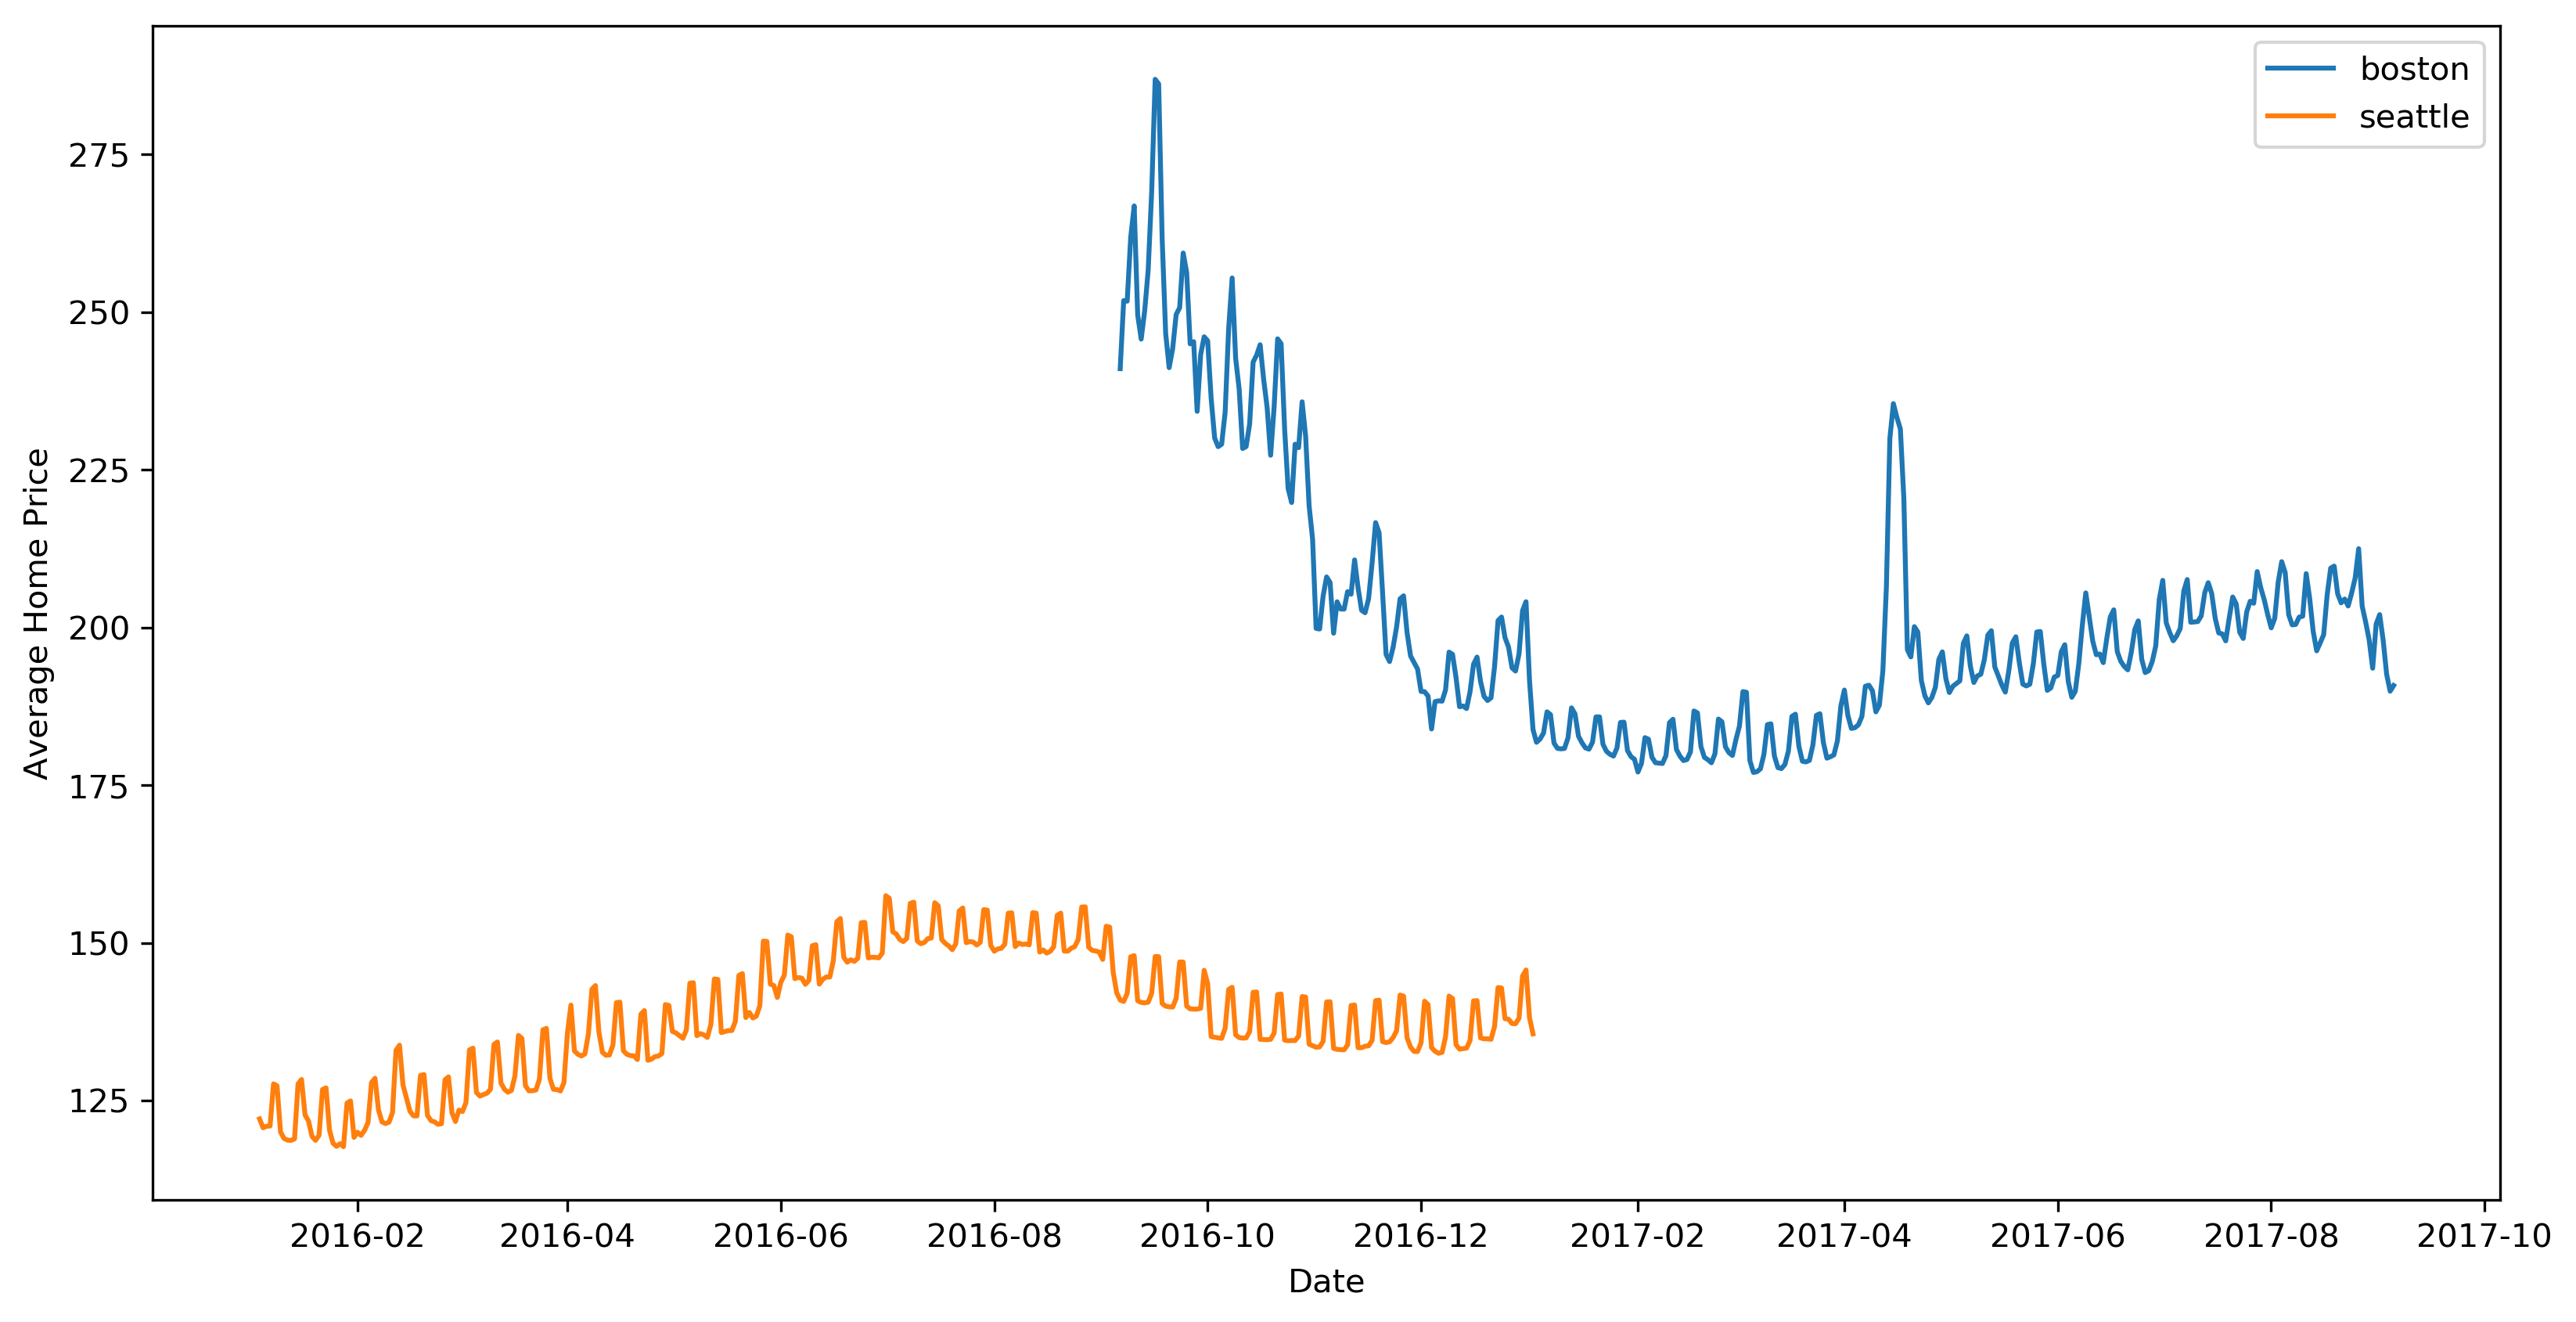

In [5]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(avg_price_date_b['price'], label='boston')
ax.plot(avg_price_date_s['price'], label='seattle')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Average Home Price');
fig.savefig('png\PriceVsDate.png', bbox_inches='tight')

In [6]:
'The average price during the Boston Marathon period in 2017 was ${}'.format(int(avg_price_date_b.loc['2017-04-14':'2017-04-17','price'].mean()))

'The average price during the Boston Marathon period in 2017 was $232'

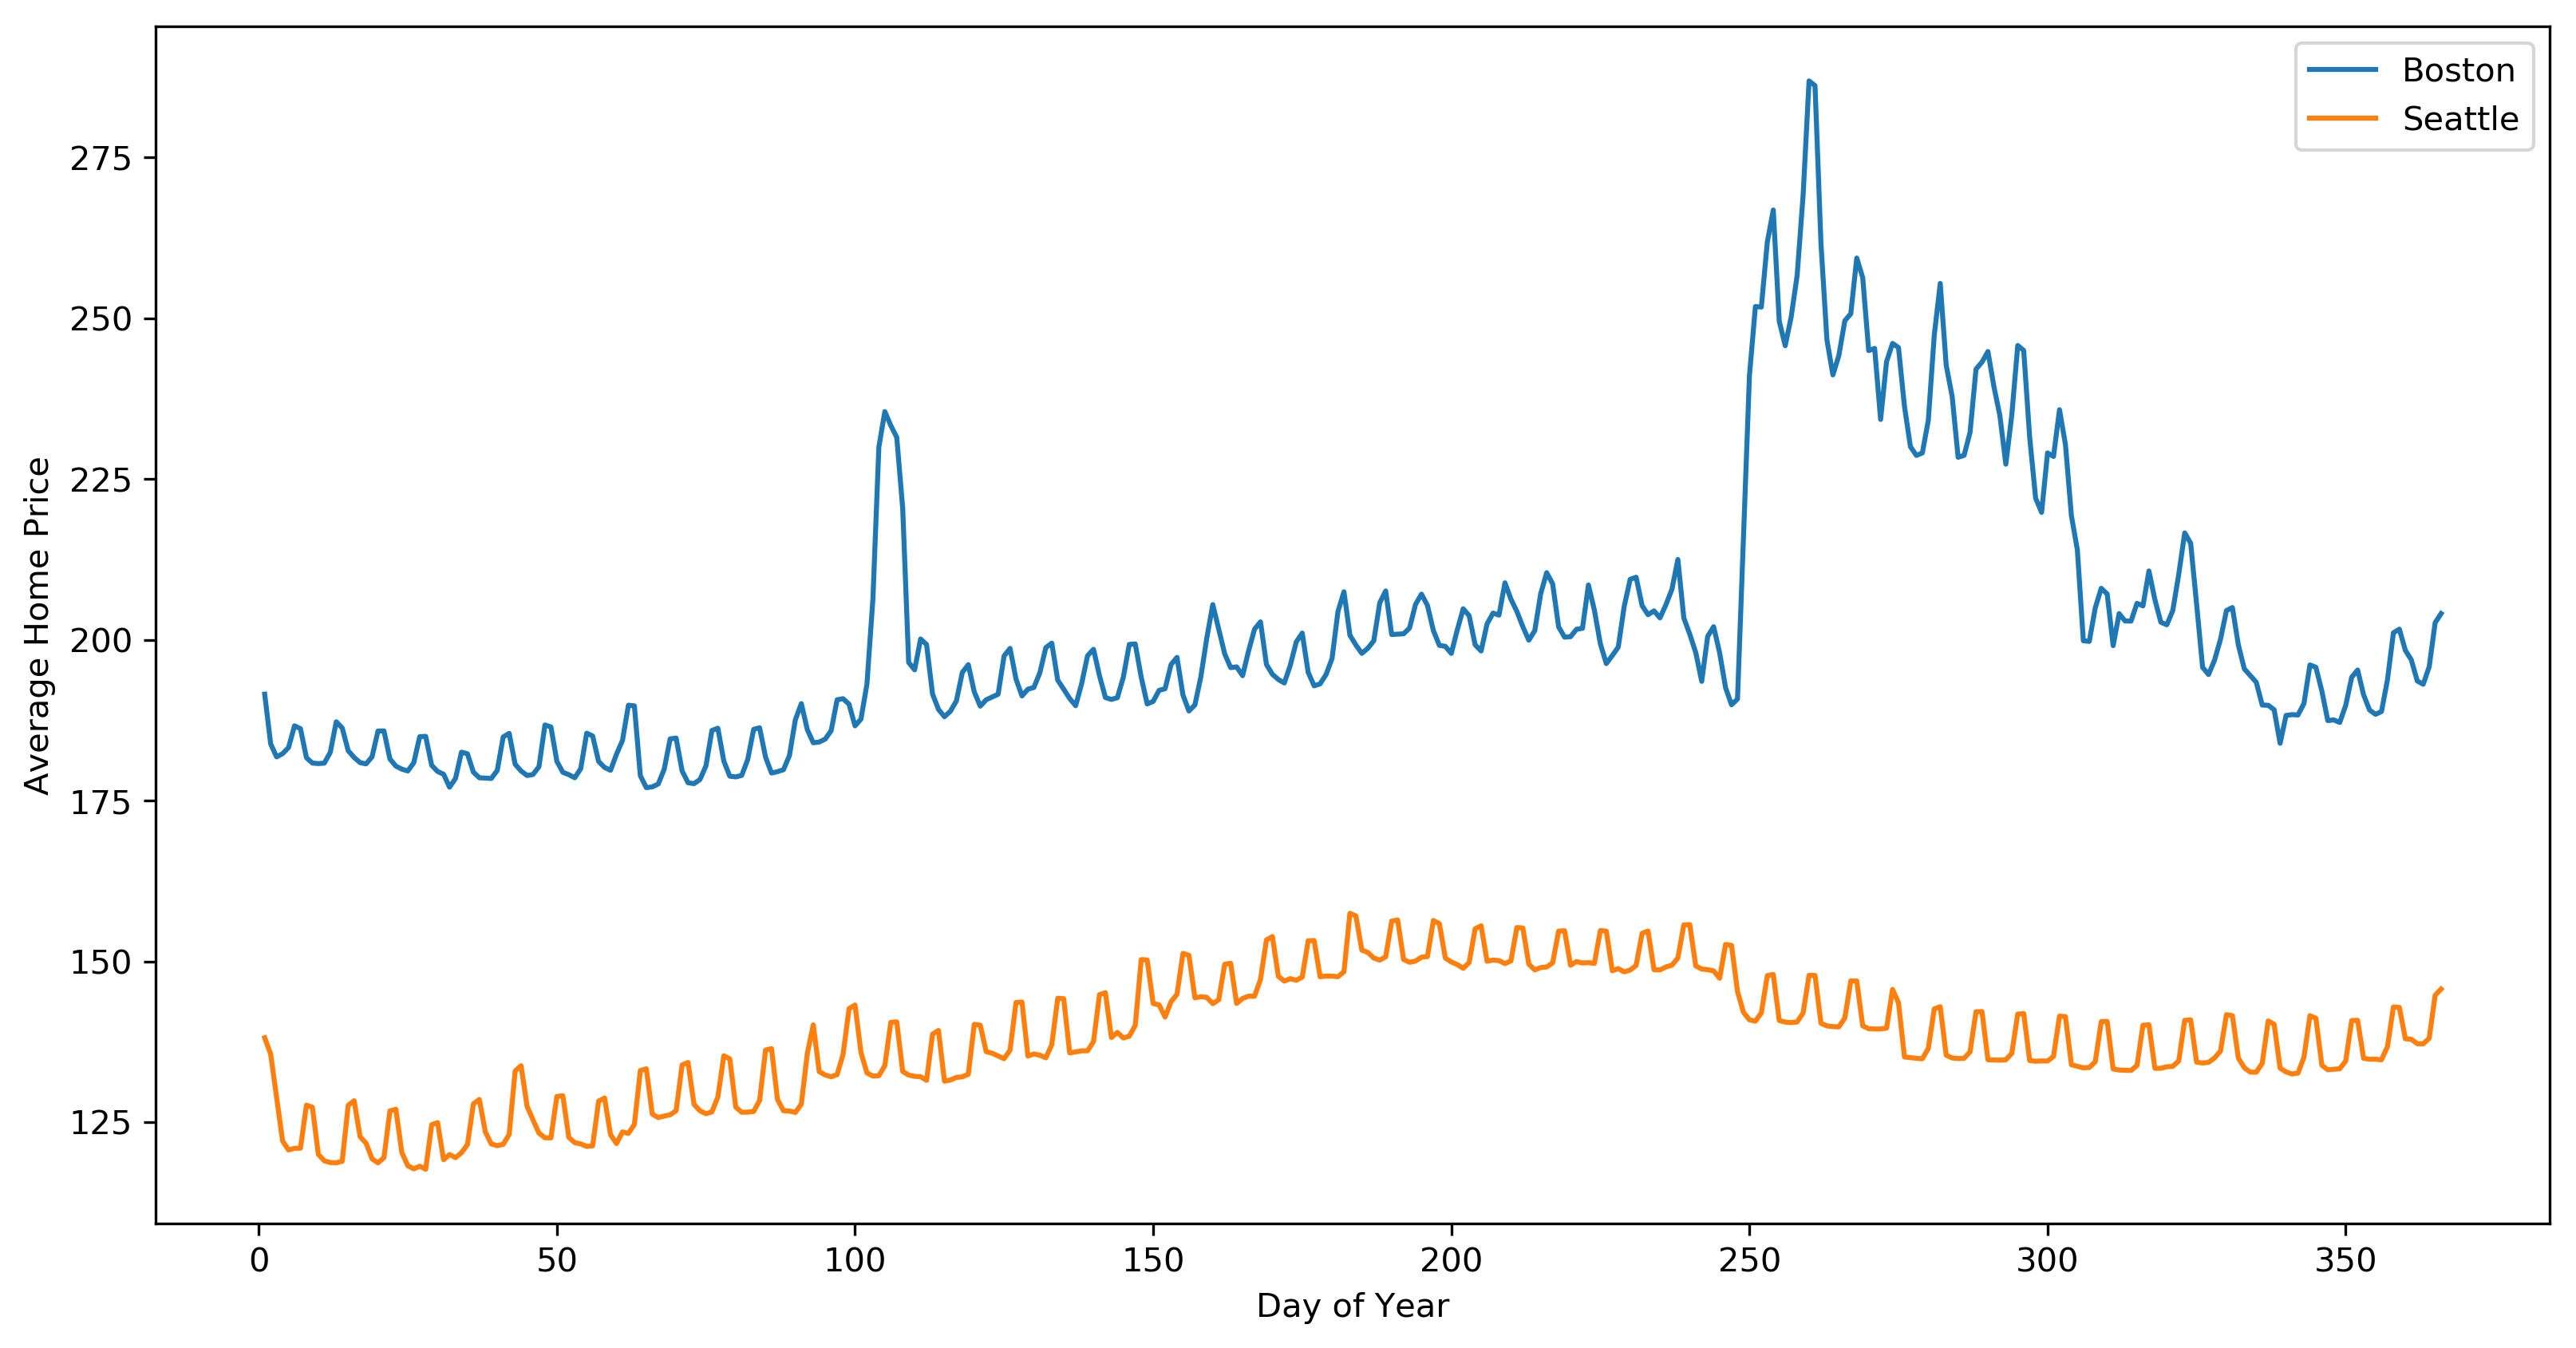

In [7]:
fig2 = plt.figure(figsize=(10,5),dpi=300)
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(avg_price_day_b['price'], label='Boston')
ax2.plot(avg_price_day_s['price'], label='Seattle');
ax2.legend()
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Average Home Price')
fig2.savefig('png\PricevsDay.png', bbox_inches='tight')

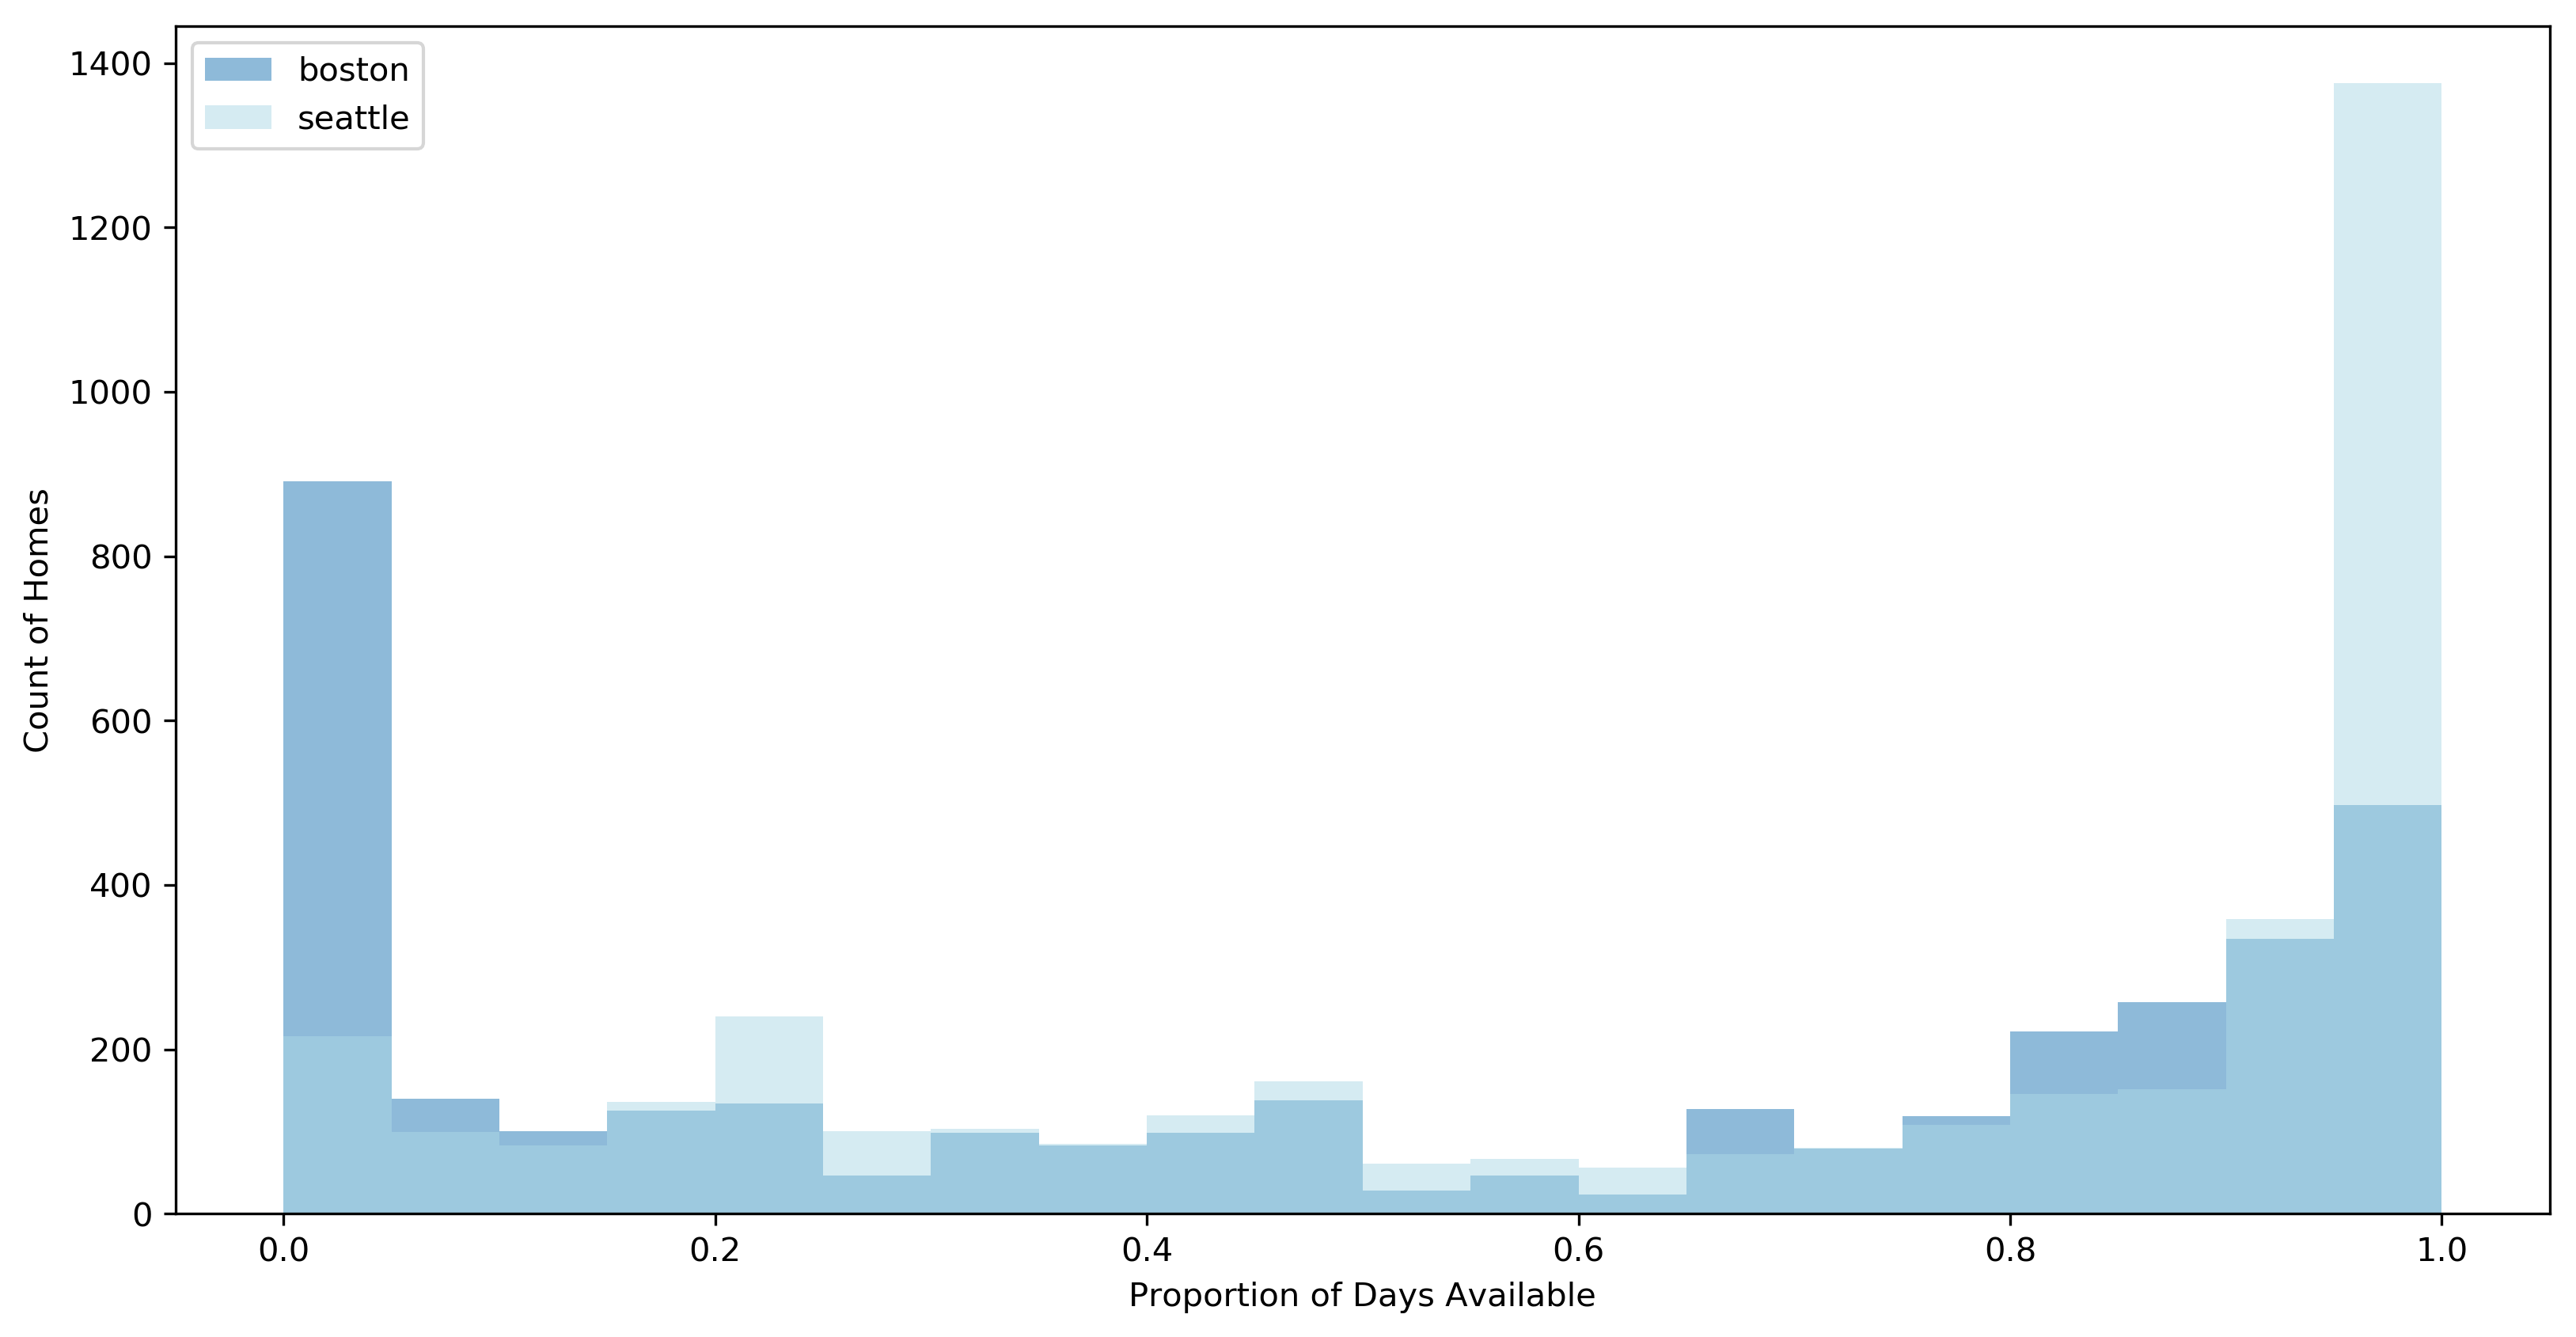

In [8]:
fig3 = plt.figure(figsize=(10,5),dpi=300)
ax3 = fig3.add_axes([0,0,1,1])
ax3.hist(boston_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='boston');
ax3.hist(seattle_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='seattle', color='lightblue')
ax3.legend()
ax3.set_xlabel('Proportion of Days Available')
ax3.set_ylabel('Count of Homes')
fig3.savefig('png\PropDaysAvailable.png', bbox_inches='tight')

In [9]:
'In Boston, at any given time, there is a %{} chance that a house is available, while in Seattle this figure is much higher at %{}'.format(int(boston_calendar['available'].mean()*100), int(seattle_calendar['available'].mean()*100))

'In Boston, at any given time, there is a %49 chance that a house is available, while in Seattle this figure is much higher at %67'

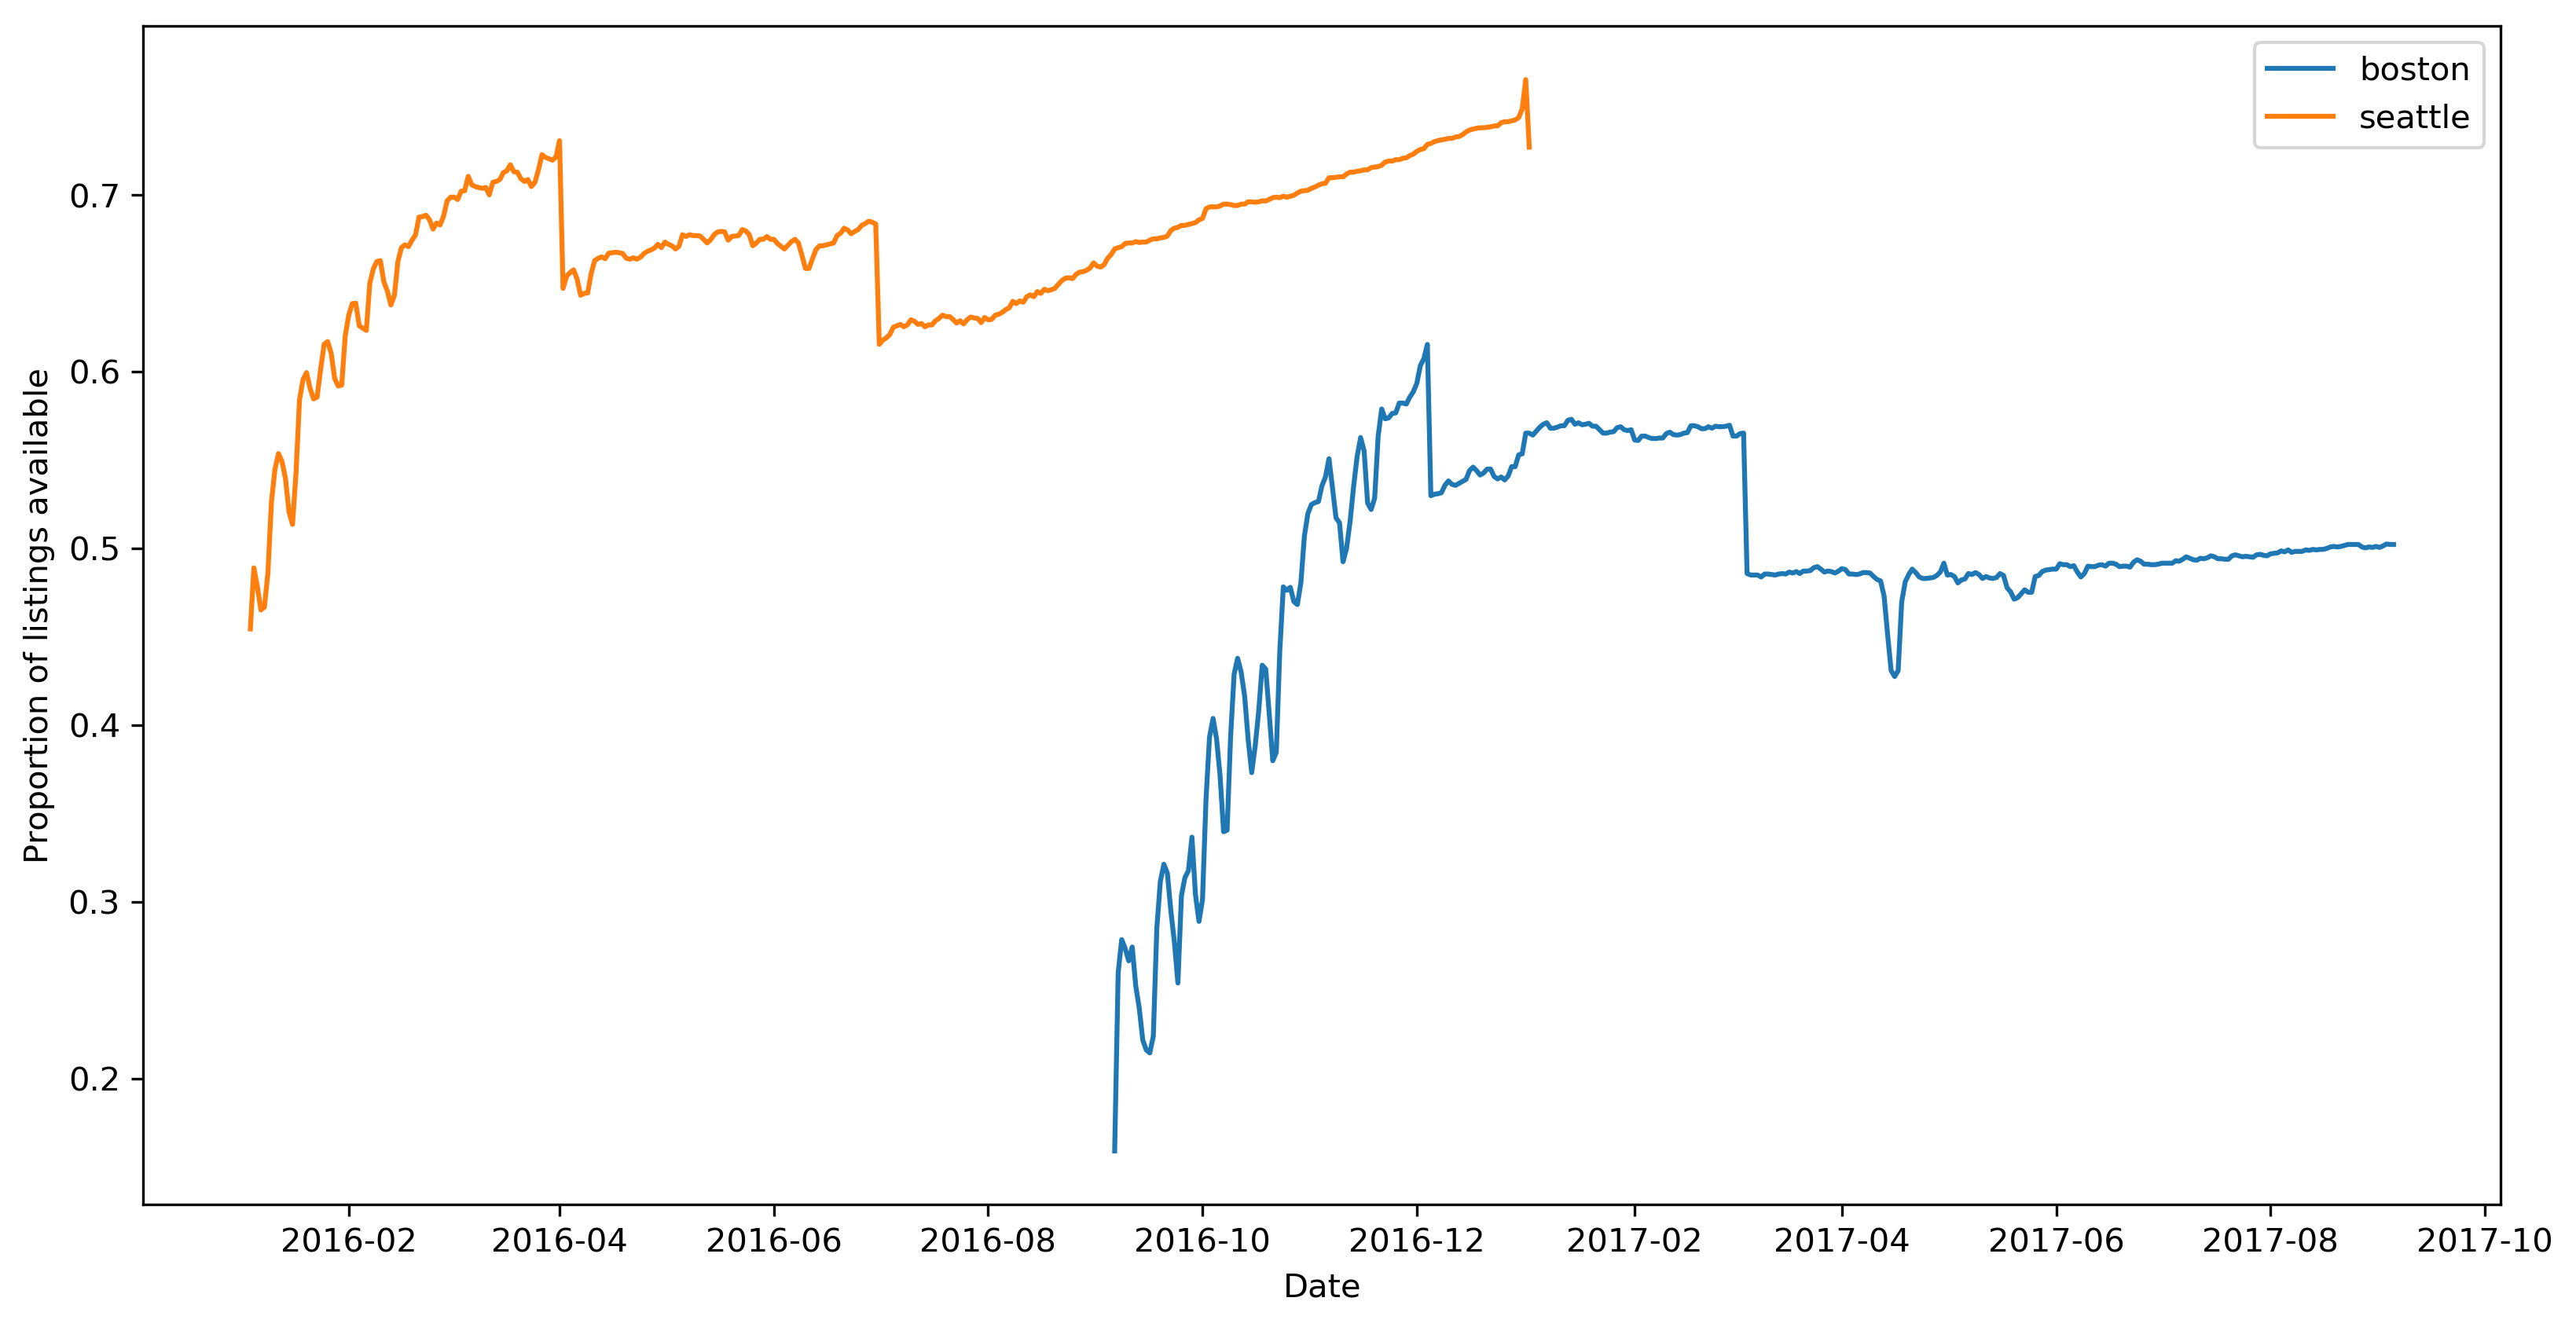

In [10]:
fig4 = plt.figure(figsize=(10,5),dpi=300)
ax4 = fig4.add_axes([0,0,1,1])
ax4.plot(boston_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='boston')
ax4.plot(seattle_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='seattle')
ax4.legend()
ax4.set_xlabel('Date')
ax4.set_ylabel('Proportion of listings available')
fig4.savefig('png\ListingsAvailableByDate.png', bbox_inches='tight')

In [11]:
reviews = pd.DataFrame(columns=['comments'])

for item in seattle_review['listing_id'].unique():
        reviews.loc[item,'comments'] = seattle_review[seattle_review['listing_id']==item]['comments'].str.cat()

for item in boston_review['listing_id'].unique():
        reviews.loc[item,'comments'] = boston_review[boston_review['listing_id']==item]['comments'].str.cat()
        
review_score_rating = pd.concat([seattle_listings.loc[:,['id','review_scores_rating']],boston_listings.loc[:,['id','review_scores_rating']]])
reviews['review_scores_rating'] = reviews.index.map(review_score_rating.set_index('id')['review_scores_rating'])
reviews.dropna(inplace=True)
#reviews.reset_index(inplace=True)

In [12]:
from sklearn.linear_model import SGDRegressor

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from math import sqrt

## Define Preprocessor converting into lower case, removing punctuation
def preprocessor(text):
    text = re.sub(r"[^a-zA-Z0-9]"," ", text)
    text = re.sub(r"'","", text)
    return text

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Define tokenizer, splitting text into tokens, while also removing stopwords, applying stemming and lemmatization as well
def tokenizer(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]
    return tokens

#Initialize Vectorizers
CV = CountVectorizer(stop_words=None, tokenizer=tokenizer, preprocessor=preprocessor, lowercase=True)
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, lowercase=True)

### Start Cross Validation Code

In [13]:
#Initialize TFIDF Vectorizer with custom preprocessor and tokenizer
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, max_features=1000)

#Create intermediate set which contains our train and validation sets, as well as
X_intermediate, X_test, y_intermediate, y_test = train_test_split(reviews['comments'], reviews['review_scores_rating'],
                                                                  shuffle=True,
                                                                  test_size=0.2)
#Set alphas to GridSearch upon
alphas = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
learning_rates = [0.01,0.001,0.0001,0.00001,0.000001]
n_estimators = [10,20,50,100,500]

kf = KFold(3, shuffle=True, random_state=21)

train_errors_sgdr = {a:[] for a in alphas}
val_errors_sgdr = {a:[] for a in alphas}
train_errors_xgb = {n:[] for n in learning_rates}
val_errors_xgb = {n:[] for n in learning_rates}
train_errors_cat = {n:[] for n in learning_rates}
val_errors_cat = {n:[] for n in learning_rates}


for train_index, val_index in kf.split(X_intermediate, y_intermediate):
    
    X_train, X_val = X_intermediate[X_intermediate.index[train_index]], X_intermediate[X_intermediate.index[val_index]]
    y_train, y_val = y_intermediate[y_intermediate.index[train_index]], y_intermediate[y_intermediate.index[val_index]]
    
    X_train = pd.DataFrame(TFIDF.fit_transform(X_train).toarray(), X_train.index)
    X_val = pd.DataFrame(TFIDF.transform(X_val).toarray(), X_val.index)
        
    #Grid Search over a number of estimators:
    #for n in n_estimators:
        #Random Forest
        #rf = RandomForestRegressor(n_).fit(X_train, y_train)
        #train_error_rf, val_error_rf = mean_squared_error(rf.predict(X_train), y_train), mean_squared_error(rf.predict(X_val), y_val)
        #train_errors_rf[n].append(train_error_rf)
        #val_errors_rf[n].append(val_error_rf)
        
        # Bagging Regressor
        #bg = BaggingRegressor(n).fit(X_train, y_train)
        #train_error_bg, val_error_bg = mean_squared_error(bg.predict(X_train), y_train), mean_squared_error(bg.predict(X_val), y_val)
        #train_errors_bg[n].append(train_error_bg)
        #val_errors_bg[n].append(val_error_bg)
        
    #Stochastic Gradient Descent
    for alpha in alphas:
        #instantiate Stochastic Gradient Descent model and fit it
        sgdr = SGDRegressor(alpha=alpha, random_state=21).fit(X_train, y_train)
    
        #calculate errors
        yhat_train = sgdr.predict(X_train)
        yhat_val = sgdr.predict(X_val)
        train_error, val_error = mean_squared_error(y_train, yhat_train), mean_squared_error(y_val, yhat_val)
        train_errors_sgdr[alpha].append(train_error)
        val_errors_sgdr[alpha].append(val_error)
    
    for lr in learning_rates:
        
        # CatBoost Regressor
        cat = CatBoostRegressor(learning_rate=lr,random_seed=21,thread_count=4).fit(X_train, y_train)
        train_error_cat, val_error_cat = mean_squared_error(cat.predict(X_train), y_train), mean_squared_error(cat.predict(X_val), y_val)
        train_errors_cat[lr].append(train_error_cat)
        val_errors_cat[lr].append(val_error_cat)
        
        # XGBoost Regressor
        xgb = XGBRegressor(learning_rate=lr,random_seed=21,n_jobs=-2)
        train_error_xgb, val_error_xgb = mean_squared_error(cat.predict(X_train), y_train), mean_squared_error(cat.predict(X_val), y_val)
        train_errors_xgb[lr].append(train_error_xgb)
        val_errors_xgb[lr].append(val_error_xgb)

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 92.6664585	total: 461ms	remaining: 7m 40s
1:	learn: 91.7659264	total: 774ms	remaining: 6m 26s
2:	learn: 90.8658215	total: 1.09s	remaining: 6m 1s
3:	learn: 89.9860121	total: 1.4s	remaining: 5m 49s
4:	learn: 89.1155377	total: 1.72s	remaining: 5m 41s
5:	learn: 88.2551828	total: 2.04s	remaining: 5m 37s
6:	learn: 87.3877082	total: 2.35s	remaining: 5m 32s
7:	learn: 86.5403129	total: 2.66s	remaining: 5m 29s
8:	learn: 85.7078340	total: 2.97s	remaining: 5m 27s
9:	learn: 84.8884817	total: 3.29s	remaining: 5m 25s
10:	learn: 84.0703280	total: 3.61s	remaining: 5m 24s
11:	learn: 83.2594892	total: 3.92s	remaining: 5m 22s
12:	learn: 82.4529512	total: 4.23s	remaining: 5m 21s
13:	learn: 81.6504681	total: 4.55s	remaining: 5m 20s
14:	learn: 80.8602950	total: 4.87s	remaining: 5m 19s
15:	learn: 80.0730740	total: 5.18s	remaining: 5m 18s
16:	learn: 79.2960733	total: 5.5s	remaining: 5m 17s
17:	learn: 78.5268030	total: 5.83s	remaining: 5m 18s
18:	learn: 77.7662358	total: 6.14s	remaining: 5m 17s
19:	le

155:	learn: 21.5567905	total: 49.1s	remaining: 4m 25s
156:	learn: 21.3723300	total: 49.4s	remaining: 4m 25s
157:	learn: 21.1912673	total: 49.7s	remaining: 4m 24s
158:	learn: 21.0121079	total: 50s	remaining: 4m 24s
159:	learn: 20.8353850	total: 50.3s	remaining: 4m 24s
160:	learn: 20.6597337	total: 50.6s	remaining: 4m 23s
161:	learn: 20.4876319	total: 50.9s	remaining: 4m 23s
162:	learn: 20.3165939	total: 51.3s	remaining: 4m 23s
163:	learn: 20.1473722	total: 51.6s	remaining: 4m 22s
164:	learn: 19.9800114	total: 51.9s	remaining: 4m 22s
165:	learn: 19.8159666	total: 52.2s	remaining: 4m 22s
166:	learn: 19.6533840	total: 52.5s	remaining: 4m 21s
167:	learn: 19.4921144	total: 52.8s	remaining: 4m 21s
168:	learn: 19.3321318	total: 53.1s	remaining: 4m 21s
169:	learn: 19.1749930	total: 53.5s	remaining: 4m 21s
170:	learn: 19.0188431	total: 53.8s	remaining: 4m 20s
171:	learn: 18.8640300	total: 54.1s	remaining: 4m 20s
172:	learn: 18.7112660	total: 54.4s	remaining: 4m 20s
173:	learn: 18.5598835	total: 

307:	learn: 8.8878236	total: 1m 36s	remaining: 3m 37s
308:	learn: 8.8652250	total: 1m 37s	remaining: 3m 36s
309:	learn: 8.8364400	total: 1m 37s	remaining: 3m 36s
310:	learn: 8.8070250	total: 1m 37s	remaining: 3m 36s
311:	learn: 8.7858909	total: 1m 37s	remaining: 3m 36s
312:	learn: 8.7596598	total: 1m 38s	remaining: 3m 35s
313:	learn: 8.7322985	total: 1m 38s	remaining: 3m 35s
314:	learn: 8.7078594	total: 1m 38s	remaining: 3m 35s
315:	learn: 8.6855937	total: 1m 39s	remaining: 3m 34s
316:	learn: 8.6617810	total: 1m 39s	remaining: 3m 34s
317:	learn: 8.6385598	total: 1m 39s	remaining: 3m 34s
318:	learn: 8.6179551	total: 1m 40s	remaining: 3m 33s
319:	learn: 8.5975849	total: 1m 40s	remaining: 3m 33s
320:	learn: 8.5789486	total: 1m 40s	remaining: 3m 33s
321:	learn: 8.5583529	total: 1m 41s	remaining: 3m 32s
322:	learn: 8.5366424	total: 1m 41s	remaining: 3m 32s
323:	learn: 8.5179133	total: 1m 41s	remaining: 3m 32s
324:	learn: 8.4969260	total: 1m 42s	remaining: 3m 32s
325:	learn: 8.4789321	total:

461:	learn: 7.1267985	total: 2m 24s	remaining: 2m 48s
462:	learn: 7.1226625	total: 2m 25s	remaining: 2m 48s
463:	learn: 7.1190619	total: 2m 25s	remaining: 2m 48s
464:	learn: 7.1146894	total: 2m 25s	remaining: 2m 47s
465:	learn: 7.1089045	total: 2m 26s	remaining: 2m 47s
466:	learn: 7.1053023	total: 2m 26s	remaining: 2m 47s
467:	learn: 7.1009000	total: 2m 26s	remaining: 2m 46s
468:	learn: 7.0975263	total: 2m 27s	remaining: 2m 46s
469:	learn: 7.0953211	total: 2m 27s	remaining: 2m 46s
470:	learn: 7.0910460	total: 2m 27s	remaining: 2m 46s
471:	learn: 7.0881495	total: 2m 28s	remaining: 2m 45s
472:	learn: 7.0828413	total: 2m 28s	remaining: 2m 45s
473:	learn: 7.0799619	total: 2m 28s	remaining: 2m 45s
474:	learn: 7.0752230	total: 2m 29s	remaining: 2m 44s
475:	learn: 7.0708563	total: 2m 29s	remaining: 2m 44s
476:	learn: 7.0680972	total: 2m 29s	remaining: 2m 44s
477:	learn: 7.0655999	total: 2m 29s	remaining: 2m 43s
478:	learn: 7.0607458	total: 2m 30s	remaining: 2m 43s
479:	learn: 7.0584454	total:

615:	learn: 6.6873421	total: 3m 12s	remaining: 2m
616:	learn: 6.6859578	total: 3m 13s	remaining: 1m 59s
617:	learn: 6.6840815	total: 3m 13s	remaining: 1m 59s
618:	learn: 6.6829695	total: 3m 13s	remaining: 1m 59s
619:	learn: 6.6818578	total: 3m 13s	remaining: 1m 58s
620:	learn: 6.6807322	total: 3m 14s	remaining: 1m 58s
621:	learn: 6.6798523	total: 3m 14s	remaining: 1m 58s
622:	learn: 6.6783134	total: 3m 14s	remaining: 1m 57s
623:	learn: 6.6773820	total: 3m 15s	remaining: 1m 57s
624:	learn: 6.6757899	total: 3m 15s	remaining: 1m 57s
625:	learn: 6.6747129	total: 3m 15s	remaining: 1m 56s
626:	learn: 6.6733045	total: 3m 16s	remaining: 1m 56s
627:	learn: 6.6705239	total: 3m 16s	remaining: 1m 56s
628:	learn: 6.6684286	total: 3m 16s	remaining: 1m 56s
629:	learn: 6.6667714	total: 3m 16s	remaining: 1m 55s
630:	learn: 6.6657081	total: 3m 17s	remaining: 1m 55s
631:	learn: 6.6639572	total: 3m 17s	remaining: 1m 55s
632:	learn: 6.6613946	total: 3m 17s	remaining: 1m 54s
633:	learn: 6.6607943	total: 3m 

767:	learn: 6.4744705	total: 3m 59s	remaining: 1m 12s
768:	learn: 6.4737261	total: 3m 59s	remaining: 1m 11s
769:	learn: 6.4733039	total: 3m 59s	remaining: 1m 11s
770:	learn: 6.4725813	total: 4m	remaining: 1m 11s
771:	learn: 6.4713414	total: 4m	remaining: 1m 11s
772:	learn: 6.4708878	total: 4m	remaining: 1m 10s
773:	learn: 6.4679708	total: 4m 1s	remaining: 1m 10s
774:	learn: 6.4668579	total: 4m 1s	remaining: 1m 10s
775:	learn: 6.4658019	total: 4m 1s	remaining: 1m 9s
776:	learn: 6.4639499	total: 4m 1s	remaining: 1m 9s
777:	learn: 6.4609910	total: 4m 2s	remaining: 1m 9s
778:	learn: 6.4588505	total: 4m 2s	remaining: 1m 8s
779:	learn: 6.4586703	total: 4m 2s	remaining: 1m 8s
780:	learn: 6.4572758	total: 4m 3s	remaining: 1m 8s
781:	learn: 6.4555088	total: 4m 3s	remaining: 1m 7s
782:	learn: 6.4542931	total: 4m 3s	remaining: 1m 7s
783:	learn: 6.4536607	total: 4m 4s	remaining: 1m 7s
784:	learn: 6.4527963	total: 4m 4s	remaining: 1m 6s
785:	learn: 6.4515462	total: 4m 4s	remaining: 1m 6s
786:	learn

923:	learn: 6.1924124	total: 4m 47s	remaining: 23.6s
924:	learn: 6.1915081	total: 4m 47s	remaining: 23.3s
925:	learn: 6.1899505	total: 4m 47s	remaining: 23s
926:	learn: 6.1872339	total: 4m 48s	remaining: 22.7s
927:	learn: 6.1832667	total: 4m 48s	remaining: 22.4s
928:	learn: 6.1821874	total: 4m 48s	remaining: 22.1s
929:	learn: 6.1810664	total: 4m 48s	remaining: 21.8s
930:	learn: 6.1785433	total: 4m 49s	remaining: 21.4s
931:	learn: 6.1761186	total: 4m 49s	remaining: 21.1s
932:	learn: 6.1742193	total: 4m 49s	remaining: 20.8s
933:	learn: 6.1711276	total: 4m 50s	remaining: 20.5s
934:	learn: 6.1681385	total: 4m 50s	remaining: 20.2s
935:	learn: 6.1646556	total: 4m 50s	remaining: 19.9s
936:	learn: 6.1628256	total: 4m 51s	remaining: 19.6s
937:	learn: 6.1604868	total: 4m 51s	remaining: 19.3s
938:	learn: 6.1579038	total: 4m 51s	remaining: 19s
939:	learn: 6.1567700	total: 4m 52s	remaining: 18.6s
940:	learn: 6.1554611	total: 4m 52s	remaining: 18.3s
941:	learn: 6.1532622	total: 4m 52s	remaining: 18s

80:	learn: 86.4895651	total: 25.4s	remaining: 4m 48s
81:	learn: 86.4052414	total: 25.7s	remaining: 4m 47s
82:	learn: 86.3209082	total: 26s	remaining: 4m 47s
83:	learn: 86.2381269	total: 26.3s	remaining: 4m 47s
84:	learn: 86.1548317	total: 26.7s	remaining: 4m 46s
85:	learn: 86.0711442	total: 27s	remaining: 4m 46s
86:	learn: 85.9876514	total: 27.3s	remaining: 4m 46s
87:	learn: 85.9046369	total: 27.6s	remaining: 4m 46s
88:	learn: 85.8220050	total: 27.9s	remaining: 4m 45s
89:	learn: 85.7378524	total: 28.2s	remaining: 4m 45s
90:	learn: 85.6546209	total: 28.5s	remaining: 4m 45s
91:	learn: 85.5708053	total: 28.9s	remaining: 4m 44s
92:	learn: 85.4870751	total: 29.2s	remaining: 4m 44s
93:	learn: 85.4038239	total: 29.5s	remaining: 4m 44s
94:	learn: 85.3212259	total: 29.8s	remaining: 4m 43s
95:	learn: 85.2386039	total: 30.1s	remaining: 4m 43s
96:	learn: 85.1560496	total: 30.4s	remaining: 4m 42s
97:	learn: 85.0742502	total: 30.7s	remaining: 4m 42s
98:	learn: 84.9910338	total: 31s	remaining: 4m 42s

234:	learn: 74.4670084	total: 1m 13s	remaining: 3m 59s
235:	learn: 74.3943398	total: 1m 13s	remaining: 3m 58s
236:	learn: 74.3226270	total: 1m 14s	remaining: 3m 58s
237:	learn: 74.2502427	total: 1m 14s	remaining: 3m 58s
238:	learn: 74.1783975	total: 1m 14s	remaining: 3m 57s
239:	learn: 74.1061407	total: 1m 15s	remaining: 3m 57s
240:	learn: 74.0341101	total: 1m 15s	remaining: 3m 57s
241:	learn: 73.9625191	total: 1m 15s	remaining: 3m 57s
242:	learn: 73.8902338	total: 1m 15s	remaining: 3m 56s
243:	learn: 73.8189812	total: 1m 16s	remaining: 3m 56s
244:	learn: 73.7468388	total: 1m 16s	remaining: 3m 56s
245:	learn: 73.6757127	total: 1m 16s	remaining: 3m 55s
246:	learn: 73.6050412	total: 1m 17s	remaining: 3m 55s
247:	learn: 73.5339825	total: 1m 17s	remaining: 3m 55s
248:	learn: 73.4626588	total: 1m 17s	remaining: 3m 54s
249:	learn: 73.3909654	total: 1m 18s	remaining: 3m 54s
250:	learn: 73.3198681	total: 1m 18s	remaining: 3m 54s
251:	learn: 73.2485302	total: 1m 18s	remaining: 3m 53s
252:	learn

383:	learn: 64.4589079	total: 1m 59s	remaining: 3m 12s
384:	learn: 64.3962320	total: 2m	remaining: 3m 11s
385:	learn: 64.3341691	total: 2m	remaining: 3m 11s
386:	learn: 64.2715868	total: 2m	remaining: 3m 11s
387:	learn: 64.2097897	total: 2m 1s	remaining: 3m 11s
388:	learn: 64.1476108	total: 2m 1s	remaining: 3m 10s
389:	learn: 64.0859154	total: 2m 1s	remaining: 3m 10s
390:	learn: 64.0237198	total: 2m 2s	remaining: 3m 10s
391:	learn: 63.9620068	total: 2m 2s	remaining: 3m 9s
392:	learn: 63.9009903	total: 2m 2s	remaining: 3m 9s
393:	learn: 63.8391932	total: 2m 2s	remaining: 3m 9s
394:	learn: 63.7774495	total: 2m 3s	remaining: 3m 8s
395:	learn: 63.7156293	total: 2m 3s	remaining: 3m 8s
396:	learn: 63.6540769	total: 2m 3s	remaining: 3m 8s
397:	learn: 63.5927022	total: 2m 4s	remaining: 3m 7s
398:	learn: 63.5312302	total: 2m 4s	remaining: 3m 7s
399:	learn: 63.4696481	total: 2m 4s	remaining: 3m 7s
400:	learn: 63.4086123	total: 2m 5s	remaining: 3m 7s
401:	learn: 63.3479203	total: 2m 5s	remaining:

534:	learn: 55.7266829	total: 2m 46s	remaining: 2m 25s
535:	learn: 55.6732856	total: 2m 47s	remaining: 2m 24s
536:	learn: 55.6195223	total: 2m 47s	remaining: 2m 24s
537:	learn: 55.5658484	total: 2m 47s	remaining: 2m 24s
538:	learn: 55.5124227	total: 2m 48s	remaining: 2m 23s
539:	learn: 55.4587294	total: 2m 48s	remaining: 2m 23s
540:	learn: 55.4054122	total: 2m 48s	remaining: 2m 23s
541:	learn: 55.3520947	total: 2m 49s	remaining: 2m 22s
542:	learn: 55.2989368	total: 2m 49s	remaining: 2m 22s
543:	learn: 55.2455263	total: 2m 49s	remaining: 2m 22s
544:	learn: 55.1923112	total: 2m 50s	remaining: 2m 22s
545:	learn: 55.1390711	total: 2m 50s	remaining: 2m 21s
546:	learn: 55.0858025	total: 2m 50s	remaining: 2m 21s
547:	learn: 55.0329398	total: 2m 51s	remaining: 2m 21s
548:	learn: 54.9802165	total: 2m 51s	remaining: 2m 20s
549:	learn: 54.9275705	total: 2m 51s	remaining: 2m 20s
550:	learn: 54.8744724	total: 2m 52s	remaining: 2m 20s
551:	learn: 54.8214574	total: 2m 52s	remaining: 2m 19s
552:	learn

685:	learn: 48.2214441	total: 3m 34s	remaining: 1m 38s
686:	learn: 48.1753418	total: 3m 34s	remaining: 1m 37s
687:	learn: 48.1291227	total: 3m 34s	remaining: 1m 37s
688:	learn: 48.0829320	total: 3m 35s	remaining: 1m 37s
689:	learn: 48.0369422	total: 3m 35s	remaining: 1m 36s
690:	learn: 47.9911035	total: 3m 35s	remaining: 1m 36s
691:	learn: 47.9454137	total: 3m 36s	remaining: 1m 36s
692:	learn: 47.8993501	total: 3m 36s	remaining: 1m 35s
693:	learn: 47.8537341	total: 3m 36s	remaining: 1m 35s
694:	learn: 47.8079700	total: 3m 36s	remaining: 1m 35s
695:	learn: 47.7623297	total: 3m 37s	remaining: 1m 34s
696:	learn: 47.7170765	total: 3m 37s	remaining: 1m 34s
697:	learn: 47.6715486	total: 3m 37s	remaining: 1m 34s
698:	learn: 47.6263973	total: 3m 38s	remaining: 1m 33s
699:	learn: 47.5809601	total: 3m 38s	remaining: 1m 33s
700:	learn: 47.5357764	total: 3m 38s	remaining: 1m 33s
701:	learn: 47.4905480	total: 3m 39s	remaining: 1m 33s
702:	learn: 47.4452381	total: 3m 39s	remaining: 1m 32s
703:	learn

837:	learn: 41.7366118	total: 4m 21s	remaining: 50.6s
838:	learn: 41.6969141	total: 4m 22s	remaining: 50.3s
839:	learn: 41.6574640	total: 4m 22s	remaining: 50s
840:	learn: 41.6182810	total: 4m 22s	remaining: 49.7s
841:	learn: 41.5789067	total: 4m 23s	remaining: 49.4s
842:	learn: 41.5399617	total: 4m 23s	remaining: 49.1s
843:	learn: 41.5008325	total: 4m 23s	remaining: 48.7s
844:	learn: 41.4618089	total: 4m 24s	remaining: 48.4s
845:	learn: 41.4228730	total: 4m 24s	remaining: 48.1s
846:	learn: 41.3837131	total: 4m 24s	remaining: 47.8s
847:	learn: 41.3445080	total: 4m 24s	remaining: 47.5s
848:	learn: 41.3055761	total: 4m 25s	remaining: 47.2s
849:	learn: 41.2667598	total: 4m 25s	remaining: 46.9s
850:	learn: 41.2275350	total: 4m 25s	remaining: 46.6s
851:	learn: 41.1887577	total: 4m 26s	remaining: 46.2s
852:	learn: 41.1498724	total: 4m 26s	remaining: 45.9s
853:	learn: 41.1108939	total: 4m 26s	remaining: 45.6s
854:	learn: 41.0723785	total: 4m 27s	remaining: 45.3s
855:	learn: 41.0336517	total: 

990:	learn: 36.1478704	total: 5m 9s	remaining: 2.81s
991:	learn: 36.1141398	total: 5m 9s	remaining: 2.5s
992:	learn: 36.0805082	total: 5m 10s	remaining: 2.19s
993:	learn: 36.0467468	total: 5m 10s	remaining: 1.87s
994:	learn: 36.0131968	total: 5m 10s	remaining: 1.56s
995:	learn: 35.9793420	total: 5m 11s	remaining: 1.25s
996:	learn: 35.9460009	total: 5m 11s	remaining: 937ms
997:	learn: 35.9127087	total: 5m 11s	remaining: 625ms
998:	learn: 35.8792423	total: 5m 12s	remaining: 312ms
999:	learn: 35.8454866	total: 5m 12s	remaining: 0us
0:	learn: 93.5766029	total: 399ms	remaining: 6m 38s
1:	learn: 93.5675072	total: 710ms	remaining: 5m 54s
2:	learn: 93.5583264	total: 1.02s	remaining: 5m 40s
3:	learn: 93.5492631	total: 1.35s	remaining: 5m 35s
4:	learn: 93.5402076	total: 1.66s	remaining: 5m 30s
5:	learn: 93.5311692	total: 1.97s	remaining: 5m 27s
6:	learn: 93.5219667	total: 2.28s	remaining: 5m 23s
7:	learn: 93.5128873	total: 2.59s	remaining: 5m 21s
8:	learn: 93.5038798	total: 2.9s	remaining: 5m 19

145:	learn: 92.2650006	total: 45.7s	remaining: 4m 27s
146:	learn: 92.2559776	total: 46s	remaining: 4m 26s
147:	learn: 92.2469591	total: 46.3s	remaining: 4m 26s
148:	learn: 92.2379801	total: 46.6s	remaining: 4m 26s
149:	learn: 92.2290104	total: 46.9s	remaining: 4m 25s
150:	learn: 92.2200489	total: 47.2s	remaining: 4m 25s
151:	learn: 92.2111349	total: 47.6s	remaining: 4m 25s
152:	learn: 92.2021735	total: 47.9s	remaining: 4m 24s
153:	learn: 92.1931364	total: 48.2s	remaining: 4m 24s
154:	learn: 92.1841549	total: 48.5s	remaining: 4m 24s
155:	learn: 92.1751658	total: 48.8s	remaining: 4m 23s
156:	learn: 92.1661600	total: 49.1s	remaining: 4m 23s
157:	learn: 92.1571644	total: 49.4s	remaining: 4m 23s
158:	learn: 92.1481948	total: 49.7s	remaining: 4m 22s
159:	learn: 92.1392418	total: 50s	remaining: 4m 22s
160:	learn: 92.1301963	total: 50.3s	remaining: 4m 22s
161:	learn: 92.1212277	total: 50.6s	remaining: 4m 21s
162:	learn: 92.1122230	total: 51s	remaining: 4m 21s
163:	learn: 92.1032129	total: 51.3

297:	learn: 90.9093941	total: 1m 33s	remaining: 3m 39s
298:	learn: 90.9005355	total: 1m 33s	remaining: 3m 39s
299:	learn: 90.8916657	total: 1m 33s	remaining: 3m 38s
300:	learn: 90.8828157	total: 1m 34s	remaining: 3m 38s
301:	learn: 90.8739716	total: 1m 34s	remaining: 3m 38s
302:	learn: 90.8651675	total: 1m 34s	remaining: 3m 37s
303:	learn: 90.8563934	total: 1m 34s	remaining: 3m 37s
304:	learn: 90.8474833	total: 1m 35s	remaining: 3m 37s
305:	learn: 90.8385537	total: 1m 35s	remaining: 3m 36s
306:	learn: 90.8296953	total: 1m 35s	remaining: 3m 36s
307:	learn: 90.8208695	total: 1m 36s	remaining: 3m 36s
308:	learn: 90.8120461	total: 1m 36s	remaining: 3m 35s
309:	learn: 90.8031687	total: 1m 36s	remaining: 3m 35s
310:	learn: 90.7942649	total: 1m 37s	remaining: 3m 35s
311:	learn: 90.7854986	total: 1m 37s	remaining: 3m 34s
312:	learn: 90.7766349	total: 1m 37s	remaining: 3m 34s
313:	learn: 90.7678555	total: 1m 38s	remaining: 3m 34s
314:	learn: 90.7590294	total: 1m 38s	remaining: 3m 34s
315:	learn

448:	learn: 89.5827451	total: 2m 20s	remaining: 2m 52s
449:	learn: 89.5740334	total: 2m 20s	remaining: 2m 51s
450:	learn: 89.5652535	total: 2m 20s	remaining: 2m 51s
451:	learn: 89.5565297	total: 2m 21s	remaining: 2m 51s
452:	learn: 89.5478950	total: 2m 21s	remaining: 2m 50s
453:	learn: 89.5391226	total: 2m 21s	remaining: 2m 50s
454:	learn: 89.5303633	total: 2m 22s	remaining: 2m 50s
455:	learn: 89.5215945	total: 2m 22s	remaining: 2m 49s
456:	learn: 89.5128833	total: 2m 22s	remaining: 2m 49s
457:	learn: 89.5041811	total: 2m 23s	remaining: 2m 49s
458:	learn: 89.4953730	total: 2m 23s	remaining: 2m 49s
459:	learn: 89.4867136	total: 2m 23s	remaining: 2m 48s
460:	learn: 89.4780338	total: 2m 24s	remaining: 2m 48s
461:	learn: 89.4692755	total: 2m 24s	remaining: 2m 48s
462:	learn: 89.4605685	total: 2m 24s	remaining: 2m 47s
463:	learn: 89.4518446	total: 2m 24s	remaining: 2m 47s
464:	learn: 89.4431452	total: 2m 25s	remaining: 2m 47s
465:	learn: 89.4344735	total: 2m 25s	remaining: 2m 46s
466:	learn

598:	learn: 88.2846607	total: 3m 7s	remaining: 2m 5s
599:	learn: 88.2760012	total: 3m 7s	remaining: 2m 4s
600:	learn: 88.2673937	total: 3m 7s	remaining: 2m 4s
601:	learn: 88.2588011	total: 3m 8s	remaining: 2m 4s
602:	learn: 88.2502085	total: 3m 8s	remaining: 2m 4s
603:	learn: 88.2416823	total: 3m 8s	remaining: 2m 3s
604:	learn: 88.2330435	total: 3m 9s	remaining: 2m 3s
605:	learn: 88.2244415	total: 3m 9s	remaining: 2m 3s
606:	learn: 88.2158545	total: 3m 9s	remaining: 2m 2s
607:	learn: 88.2072774	total: 3m 9s	remaining: 2m 2s
608:	learn: 88.1987128	total: 3m 10s	remaining: 2m 2s
609:	learn: 88.1901269	total: 3m 10s	remaining: 2m 1s
610:	learn: 88.1814793	total: 3m 10s	remaining: 2m 1s
611:	learn: 88.1729604	total: 3m 11s	remaining: 2m 1s
612:	learn: 88.1643821	total: 3m 11s	remaining: 2m
613:	learn: 88.1557392	total: 3m 11s	remaining: 2m
614:	learn: 88.1471881	total: 3m 12s	remaining: 2m
615:	learn: 88.1387064	total: 3m 12s	remaining: 1m 59s
616:	learn: 88.1301054	total: 3m 12s	remaining

748:	learn: 87.0058510	total: 3m 54s	remaining: 1m 18s
749:	learn: 86.9974059	total: 3m 54s	remaining: 1m 18s
750:	learn: 86.9889916	total: 3m 54s	remaining: 1m 17s
751:	learn: 86.9806157	total: 3m 55s	remaining: 1m 17s
752:	learn: 86.9721381	total: 3m 55s	remaining: 1m 17s
753:	learn: 86.9637021	total: 3m 55s	remaining: 1m 16s
754:	learn: 86.9552230	total: 3m 55s	remaining: 1m 16s
755:	learn: 86.9467875	total: 3m 56s	remaining: 1m 16s
756:	learn: 86.9383282	total: 3m 56s	remaining: 1m 15s
757:	learn: 86.9299396	total: 3m 56s	remaining: 1m 15s
758:	learn: 86.9214861	total: 3m 57s	remaining: 1m 15s
759:	learn: 86.9130259	total: 3m 57s	remaining: 1m 15s
760:	learn: 86.9044804	total: 3m 57s	remaining: 1m 14s
761:	learn: 86.8960186	total: 3m 58s	remaining: 1m 14s
762:	learn: 86.8876017	total: 3m 58s	remaining: 1m 14s
763:	learn: 86.8791376	total: 3m 58s	remaining: 1m 13s
764:	learn: 86.8706651	total: 3m 59s	remaining: 1m 13s
765:	learn: 86.8622417	total: 3m 59s	remaining: 1m 13s
766:	learn

901:	learn: 85.7217829	total: 4m 41s	remaining: 30.6s
902:	learn: 85.7134174	total: 4m 42s	remaining: 30.3s
903:	learn: 85.7050718	total: 4m 42s	remaining: 30s
904:	learn: 85.6967040	total: 4m 42s	remaining: 29.7s
905:	learn: 85.6883476	total: 4m 43s	remaining: 29.4s
906:	learn: 85.6799771	total: 4m 43s	remaining: 29.1s
907:	learn: 85.6715991	total: 4m 43s	remaining: 28.7s
908:	learn: 85.6632627	total: 4m 44s	remaining: 28.4s
909:	learn: 85.6548986	total: 4m 44s	remaining: 28.1s
910:	learn: 85.6465991	total: 4m 44s	remaining: 27.8s
911:	learn: 85.6383733	total: 4m 44s	remaining: 27.5s
912:	learn: 85.6300978	total: 4m 45s	remaining: 27.2s
913:	learn: 85.6217432	total: 4m 45s	remaining: 26.9s
914:	learn: 85.6134260	total: 4m 45s	remaining: 26.6s
915:	learn: 85.6050368	total: 4m 46s	remaining: 26.2s
916:	learn: 85.5967008	total: 4m 46s	remaining: 25.9s
917:	learn: 85.5883406	total: 4m 46s	remaining: 25.6s
918:	learn: 85.5800279	total: 4m 47s	remaining: 25.3s
919:	learn: 85.5717349	total: 

56:	learn: 93.5338691	total: 17.9s	remaining: 4m 55s
57:	learn: 93.5329745	total: 18.2s	remaining: 4m 55s
58:	learn: 93.5320755	total: 18.5s	remaining: 4m 55s
59:	learn: 93.5311656	total: 18.8s	remaining: 4m 55s
60:	learn: 93.5302499	total: 19.1s	remaining: 4m 54s
61:	learn: 93.5293346	total: 19.4s	remaining: 4m 54s
62:	learn: 93.5284190	total: 19.8s	remaining: 4m 53s
63:	learn: 93.5275154	total: 20.1s	remaining: 4m 53s
64:	learn: 93.5265974	total: 20.4s	remaining: 4m 53s
65:	learn: 93.5256773	total: 20.7s	remaining: 4m 52s
66:	learn: 93.5247740	total: 21s	remaining: 4m 52s
67:	learn: 93.5238655	total: 21.3s	remaining: 4m 52s
68:	learn: 93.5229536	total: 21.6s	remaining: 4m 51s
69:	learn: 93.5220491	total: 21.9s	remaining: 4m 51s
70:	learn: 93.5211365	total: 22.3s	remaining: 4m 51s
71:	learn: 93.5202277	total: 22.6s	remaining: 4m 50s
72:	learn: 93.5193248	total: 22.9s	remaining: 4m 50s
73:	learn: 93.5184121	total: 23.2s	remaining: 4m 50s
74:	learn: 93.5174989	total: 23.5s	remaining: 4m

210:	learn: 93.3936858	total: 1m 6s	remaining: 4m 7s
211:	learn: 93.3927887	total: 1m 6s	remaining: 4m 7s
212:	learn: 93.3918777	total: 1m 6s	remaining: 4m 6s
213:	learn: 93.3909631	total: 1m 7s	remaining: 4m 6s
214:	learn: 93.3900555	total: 1m 7s	remaining: 4m 6s
215:	learn: 93.3891657	total: 1m 7s	remaining: 4m 5s
216:	learn: 93.3882518	total: 1m 8s	remaining: 4m 5s
217:	learn: 93.3873496	total: 1m 8s	remaining: 4m 5s
218:	learn: 93.3864504	total: 1m 8s	remaining: 4m 4s
219:	learn: 93.3855448	total: 1m 8s	remaining: 4m 4s
220:	learn: 93.3846313	total: 1m 9s	remaining: 4m 4s
221:	learn: 93.3837141	total: 1m 9s	remaining: 4m 3s
222:	learn: 93.3828008	total: 1m 9s	remaining: 4m 3s
223:	learn: 93.3818930	total: 1m 10s	remaining: 4m 3s
224:	learn: 93.3809785	total: 1m 10s	remaining: 4m 2s
225:	learn: 93.3800623	total: 1m 10s	remaining: 4m 2s
226:	learn: 93.3791527	total: 1m 11s	remaining: 4m 2s
227:	learn: 93.3782516	total: 1m 11s	remaining: 4m 1s
228:	learn: 93.3773376	total: 1m 11s	rema

360:	learn: 93.2573670	total: 1m 52s	remaining: 3m 19s
361:	learn: 93.2564604	total: 1m 53s	remaining: 3m 19s
362:	learn: 93.2555621	total: 1m 53s	remaining: 3m 19s
363:	learn: 93.2546490	total: 1m 53s	remaining: 3m 19s
364:	learn: 93.2537381	total: 1m 54s	remaining: 3m 18s
365:	learn: 93.2528375	total: 1m 54s	remaining: 3m 18s
366:	learn: 93.2519221	total: 1m 54s	remaining: 3m 18s
367:	learn: 93.2510153	total: 1m 55s	remaining: 3m 17s
368:	learn: 93.2501071	total: 1m 55s	remaining: 3m 17s
369:	learn: 93.2491989	total: 1m 55s	remaining: 3m 17s
370:	learn: 93.2482893	total: 1m 56s	remaining: 3m 16s
371:	learn: 93.2473815	total: 1m 56s	remaining: 3m 16s
372:	learn: 93.2464645	total: 1m 56s	remaining: 3m 16s
373:	learn: 93.2455578	total: 1m 57s	remaining: 3m 15s
374:	learn: 93.2446504	total: 1m 57s	remaining: 3m 15s
375:	learn: 93.2437367	total: 1m 57s	remaining: 3m 15s
376:	learn: 93.2428326	total: 1m 57s	remaining: 3m 14s
377:	learn: 93.2419256	total: 1m 58s	remaining: 3m 14s
378:	learn

511:	learn: 93.1203087	total: 2m 40s	remaining: 2m 32s
512:	learn: 93.1194030	total: 2m 40s	remaining: 2m 32s
513:	learn: 93.1184957	total: 2m 40s	remaining: 2m 32s
514:	learn: 93.1175865	total: 2m 41s	remaining: 2m 31s
515:	learn: 93.1166820	total: 2m 41s	remaining: 2m 31s
516:	learn: 93.1157734	total: 2m 41s	remaining: 2m 31s
517:	learn: 93.1148746	total: 2m 42s	remaining: 2m 30s
518:	learn: 93.1139677	total: 2m 42s	remaining: 2m 30s
519:	learn: 93.1130556	total: 2m 42s	remaining: 2m 30s
520:	learn: 93.1121491	total: 2m 43s	remaining: 2m 29s
521:	learn: 93.1112522	total: 2m 43s	remaining: 2m 29s
522:	learn: 93.1103491	total: 2m 43s	remaining: 2m 29s
523:	learn: 93.1094409	total: 2m 44s	remaining: 2m 29s
524:	learn: 93.1085334	total: 2m 44s	remaining: 2m 28s
525:	learn: 93.1076332	total: 2m 44s	remaining: 2m 28s
526:	learn: 93.1067292	total: 2m 45s	remaining: 2m 28s
527:	learn: 93.1058260	total: 2m 45s	remaining: 2m 27s
528:	learn: 93.1049184	total: 2m 45s	remaining: 2m 27s
529:	learn

662:	learn: 92.9835601	total: 3m 27s	remaining: 1m 45s
663:	learn: 92.9826533	total: 3m 27s	remaining: 1m 45s
664:	learn: 92.9817458	total: 3m 28s	remaining: 1m 44s
665:	learn: 92.9808382	total: 3m 28s	remaining: 1m 44s
666:	learn: 92.9799292	total: 3m 28s	remaining: 1m 44s
667:	learn: 92.9790259	total: 3m 29s	remaining: 1m 43s
668:	learn: 92.9781191	total: 3m 29s	remaining: 1m 43s
669:	learn: 92.9772043	total: 3m 29s	remaining: 1m 43s
670:	learn: 92.9762933	total: 3m 30s	remaining: 1m 43s
671:	learn: 92.9753859	total: 3m 30s	remaining: 1m 42s
672:	learn: 92.9744758	total: 3m 30s	remaining: 1m 42s
673:	learn: 92.9735703	total: 3m 31s	remaining: 1m 42s
674:	learn: 92.9726585	total: 3m 31s	remaining: 1m 41s
675:	learn: 92.9717578	total: 3m 31s	remaining: 1m 41s
676:	learn: 92.9708599	total: 3m 32s	remaining: 1m 41s
677:	learn: 92.9699525	total: 3m 32s	remaining: 1m 40s
678:	learn: 92.9690487	total: 3m 32s	remaining: 1m 40s
679:	learn: 92.9681466	total: 3m 32s	remaining: 1m 40s
680:	learn

813:	learn: 92.8469199	total: 4m 14s	remaining: 58.3s
814:	learn: 92.8460098	total: 4m 15s	remaining: 57.9s
815:	learn: 92.8451083	total: 4m 15s	remaining: 57.6s
816:	learn: 92.8442105	total: 4m 15s	remaining: 57.3s
817:	learn: 92.8433230	total: 4m 16s	remaining: 57s
818:	learn: 92.8424202	total: 4m 16s	remaining: 56.7s
819:	learn: 92.8415102	total: 4m 16s	remaining: 56.4s
820:	learn: 92.8406052	total: 4m 17s	remaining: 56.1s
821:	learn: 92.8397073	total: 4m 17s	remaining: 55.7s
822:	learn: 92.8388009	total: 4m 17s	remaining: 55.4s
823:	learn: 92.8378943	total: 4m 18s	remaining: 55.1s
824:	learn: 92.8369972	total: 4m 18s	remaining: 54.8s
825:	learn: 92.8360976	total: 4m 18s	remaining: 54.5s
826:	learn: 92.8351894	total: 4m 18s	remaining: 54.2s
827:	learn: 92.8342846	total: 4m 19s	remaining: 53.9s
828:	learn: 92.8333842	total: 4m 19s	remaining: 53.6s
829:	learn: 92.8324809	total: 4m 19s	remaining: 53.2s
830:	learn: 92.8315776	total: 4m 20s	remaining: 52.9s
831:	learn: 92.8306778	total: 

966:	learn: 92.7088021	total: 5m 2s	remaining: 10.3s
967:	learn: 92.7079027	total: 5m 3s	remaining: 10s
968:	learn: 92.7070018	total: 5m 3s	remaining: 9.7s
969:	learn: 92.7060957	total: 5m 3s	remaining: 9.39s
970:	learn: 92.7052001	total: 5m 3s	remaining: 9.08s
971:	learn: 92.7042989	total: 5m 4s	remaining: 8.77s
972:	learn: 92.7033894	total: 5m 4s	remaining: 8.45s
973:	learn: 92.7024830	total: 5m 4s	remaining: 8.14s
974:	learn: 92.7015761	total: 5m 5s	remaining: 7.83s
975:	learn: 92.7006749	total: 5m 5s	remaining: 7.51s
976:	learn: 92.6997751	total: 5m 5s	remaining: 7.2s
977:	learn: 92.6988754	total: 5m 6s	remaining: 6.89s
978:	learn: 92.6979777	total: 5m 6s	remaining: 6.57s
979:	learn: 92.6970667	total: 5m 6s	remaining: 6.26s
980:	learn: 92.6961582	total: 5m 7s	remaining: 5.95s
981:	learn: 92.6952556	total: 5m 7s	remaining: 5.63s
982:	learn: 92.6943516	total: 5m 7s	remaining: 5.32s
983:	learn: 92.6934553	total: 5m 8s	remaining: 5.01s
984:	learn: 92.6925529	total: 5m 8s	remaining: 4.7

122:	learn: 93.5745924	total: 38.5s	remaining: 4m 34s
123:	learn: 93.5745018	total: 38.8s	remaining: 4m 33s
124:	learn: 93.5744102	total: 39.1s	remaining: 4m 33s
125:	learn: 93.5743195	total: 39.4s	remaining: 4m 33s
126:	learn: 93.5742279	total: 39.7s	remaining: 4m 32s
127:	learn: 93.5741375	total: 40s	remaining: 4m 32s
128:	learn: 93.5740461	total: 40.3s	remaining: 4m 32s
129:	learn: 93.5739541	total: 40.6s	remaining: 4m 31s
130:	learn: 93.5738630	total: 40.9s	remaining: 4m 31s
131:	learn: 93.5737720	total: 41.2s	remaining: 4m 31s
132:	learn: 93.5736809	total: 41.5s	remaining: 4m 30s
133:	learn: 93.5735895	total: 41.9s	remaining: 4m 30s
134:	learn: 93.5734976	total: 42.2s	remaining: 4m 30s
135:	learn: 93.5734060	total: 42.5s	remaining: 4m 29s
136:	learn: 93.5733144	total: 42.8s	remaining: 4m 29s
137:	learn: 93.5732232	total: 43.1s	remaining: 4m 29s
138:	learn: 93.5731316	total: 43.4s	remaining: 4m 28s
139:	learn: 93.5730398	total: 43.7s	remaining: 4m 28s
140:	learn: 93.5729482	total: 

274:	learn: 93.5607379	total: 1m 25s	remaining: 3m 45s
275:	learn: 93.5606469	total: 1m 25s	remaining: 3m 45s
276:	learn: 93.5605554	total: 1m 26s	remaining: 3m 44s
277:	learn: 93.5604639	total: 1m 26s	remaining: 3m 44s
278:	learn: 93.5603737	total: 1m 26s	remaining: 3m 44s
279:	learn: 93.5602819	total: 1m 27s	remaining: 3m 43s
280:	learn: 93.5601905	total: 1m 27s	remaining: 3m 43s
281:	learn: 93.5600993	total: 1m 27s	remaining: 3m 43s
282:	learn: 93.5600078	total: 1m 27s	remaining: 3m 42s
283:	learn: 93.5599172	total: 1m 28s	remaining: 3m 42s
284:	learn: 93.5598264	total: 1m 28s	remaining: 3m 42s
285:	learn: 93.5597355	total: 1m 28s	remaining: 3m 42s
286:	learn: 93.5596442	total: 1m 29s	remaining: 3m 41s
287:	learn: 93.5595524	total: 1m 29s	remaining: 3m 41s
288:	learn: 93.5594622	total: 1m 29s	remaining: 3m 41s
289:	learn: 93.5593710	total: 1m 30s	remaining: 3m 40s
290:	learn: 93.5592792	total: 1m 30s	remaining: 3m 40s
291:	learn: 93.5591883	total: 1m 30s	remaining: 3m 40s
292:	learn

425:	learn: 93.5469754	total: 2m 12s	remaining: 2m 58s
426:	learn: 93.5468850	total: 2m 12s	remaining: 2m 57s
427:	learn: 93.5467945	total: 2m 12s	remaining: 2m 57s
428:	learn: 93.5467029	total: 2m 13s	remaining: 2m 57s
429:	learn: 93.5466111	total: 2m 13s	remaining: 2m 56s
430:	learn: 93.5465201	total: 2m 13s	remaining: 2m 56s
431:	learn: 93.5464284	total: 2m 14s	remaining: 2m 56s
432:	learn: 93.5463369	total: 2m 14s	remaining: 2m 55s
433:	learn: 93.5462456	total: 2m 14s	remaining: 2m 55s
434:	learn: 93.5461545	total: 2m 14s	remaining: 2m 55s
435:	learn: 93.5460637	total: 2m 15s	remaining: 2m 55s
436:	learn: 93.5459726	total: 2m 15s	remaining: 2m 54s
437:	learn: 93.5458819	total: 2m 15s	remaining: 2m 54s
438:	learn: 93.5457903	total: 2m 16s	remaining: 2m 54s
439:	learn: 93.5456993	total: 2m 16s	remaining: 2m 53s
440:	learn: 93.5456081	total: 2m 16s	remaining: 2m 53s
441:	learn: 93.5455176	total: 2m 17s	remaining: 2m 53s
442:	learn: 93.5454267	total: 2m 17s	remaining: 2m 52s
443:	learn

574:	learn: 93.5334024	total: 2m 58s	remaining: 2m 11s
575:	learn: 93.5333110	total: 2m 58s	remaining: 2m 11s
576:	learn: 93.5332197	total: 2m 58s	remaining: 2m 11s
577:	learn: 93.5331288	total: 2m 59s	remaining: 2m 10s
578:	learn: 93.5330380	total: 2m 59s	remaining: 2m 10s
579:	learn: 93.5329475	total: 2m 59s	remaining: 2m 10s
580:	learn: 93.5328563	total: 3m	remaining: 2m 9s
581:	learn: 93.5327649	total: 3m	remaining: 2m 9s
582:	learn: 93.5326733	total: 3m	remaining: 2m 9s
583:	learn: 93.5325830	total: 3m 1s	remaining: 2m 9s
584:	learn: 93.5324923	total: 3m 1s	remaining: 2m 8s
585:	learn: 93.5324009	total: 3m 1s	remaining: 2m 8s
586:	learn: 93.5323113	total: 3m 2s	remaining: 2m 8s
587:	learn: 93.5322198	total: 3m 2s	remaining: 2m 7s
588:	learn: 93.5321289	total: 3m 2s	remaining: 2m 7s
589:	learn: 93.5320373	total: 3m 2s	remaining: 2m 7s
590:	learn: 93.5319462	total: 3m 3s	remaining: 2m 6s
591:	learn: 93.5318543	total: 3m 3s	remaining: 2m 6s
592:	learn: 93.5317643	total: 3m 3s	remaini

725:	learn: 93.5196540	total: 3m 45s	remaining: 1m 25s
726:	learn: 93.5195628	total: 3m 45s	remaining: 1m 24s
727:	learn: 93.5194720	total: 3m 45s	remaining: 1m 24s
728:	learn: 93.5193809	total: 3m 46s	remaining: 1m 24s
729:	learn: 93.5192892	total: 3m 46s	remaining: 1m 23s
730:	learn: 93.5191980	total: 3m 46s	remaining: 1m 23s
731:	learn: 93.5191066	total: 3m 47s	remaining: 1m 23s
732:	learn: 93.5190158	total: 3m 47s	remaining: 1m 22s
733:	learn: 93.5189246	total: 3m 47s	remaining: 1m 22s
734:	learn: 93.5188329	total: 3m 48s	remaining: 1m 22s
735:	learn: 93.5187419	total: 3m 48s	remaining: 1m 21s
736:	learn: 93.5186503	total: 3m 48s	remaining: 1m 21s
737:	learn: 93.5185598	total: 3m 49s	remaining: 1m 21s
738:	learn: 93.5184685	total: 3m 49s	remaining: 1m 21s
739:	learn: 93.5183783	total: 3m 49s	remaining: 1m 20s
740:	learn: 93.5182874	total: 3m 50s	remaining: 1m 20s
741:	learn: 93.5181959	total: 3m 50s	remaining: 1m 20s
742:	learn: 93.5181048	total: 3m 50s	remaining: 1m 19s
743:	learn

878:	learn: 93.5057281	total: 4m 32s	remaining: 37.5s
879:	learn: 93.5056367	total: 4m 33s	remaining: 37.2s
880:	learn: 93.5055459	total: 4m 33s	remaining: 36.9s
881:	learn: 93.5054550	total: 4m 33s	remaining: 36.6s
882:	learn: 93.5053639	total: 4m 34s	remaining: 36.3s
883:	learn: 93.5052736	total: 4m 34s	remaining: 36s
884:	learn: 93.5051820	total: 4m 34s	remaining: 35.7s
885:	learn: 93.5050913	total: 4m 34s	remaining: 35.4s
886:	learn: 93.5050008	total: 4m 35s	remaining: 35.1s
887:	learn: 93.5049089	total: 4m 35s	remaining: 34.8s
888:	learn: 93.5048181	total: 4m 35s	remaining: 34.4s
889:	learn: 93.5047267	total: 4m 36s	remaining: 34.1s
890:	learn: 93.5046355	total: 4m 36s	remaining: 33.8s
891:	learn: 93.5045441	total: 4m 36s	remaining: 33.5s
892:	learn: 93.5044539	total: 4m 37s	remaining: 33.2s
893:	learn: 93.5043633	total: 4m 37s	remaining: 32.9s
894:	learn: 93.5042725	total: 4m 37s	remaining: 32.6s
895:	learn: 93.5041810	total: 4m 38s	remaining: 32.3s
896:	learn: 93.5040907	total: 

32:	learn: 67.9062514	total: 10.5s	remaining: 5m 6s
33:	learn: 67.2498925	total: 10.8s	remaining: 5m 6s
34:	learn: 66.5956397	total: 11.1s	remaining: 5m 5s
35:	learn: 65.9552956	total: 11.4s	remaining: 5m 5s
36:	learn: 65.3165005	total: 11.7s	remaining: 5m 4s
37:	learn: 64.6886967	total: 12s	remaining: 5m 4s
38:	learn: 64.0622720	total: 12.3s	remaining: 5m 3s
39:	learn: 63.4418490	total: 12.6s	remaining: 5m 3s
40:	learn: 62.8273371	total: 13s	remaining: 5m 3s
41:	learn: 62.2171749	total: 13.3s	remaining: 5m 2s
42:	learn: 61.6189266	total: 13.6s	remaining: 5m 2s
43:	learn: 61.0225640	total: 13.9s	remaining: 5m 1s
44:	learn: 60.4380675	total: 14.3s	remaining: 5m 2s
45:	learn: 59.8528674	total: 14.6s	remaining: 5m 2s
46:	learn: 59.2743495	total: 14.9s	remaining: 5m 2s
47:	learn: 58.7038872	total: 15.2s	remaining: 5m 1s
48:	learn: 58.1463114	total: 15.5s	remaining: 5m 1s
49:	learn: 57.5869348	total: 15.8s	remaining: 5m
50:	learn: 57.0342478	total: 16.2s	remaining: 5m
51:	learn: 56.4813501	

187:	learn: 16.5508563	total: 59.1s	remaining: 4m 15s
188:	learn: 16.4246060	total: 59.4s	remaining: 4m 14s
189:	learn: 16.2972463	total: 59.8s	remaining: 4m 14s
190:	learn: 16.1714528	total: 1m	remaining: 4m 14s
191:	learn: 16.0482049	total: 1m	remaining: 4m 14s
192:	learn: 15.9270580	total: 1m	remaining: 4m 14s
193:	learn: 15.8087803	total: 1m 1s	remaining: 4m 13s
194:	learn: 15.6911242	total: 1m 1s	remaining: 4m 13s
195:	learn: 15.5732796	total: 1m 1s	remaining: 4m 13s
196:	learn: 15.4588042	total: 1m 2s	remaining: 4m 12s
197:	learn: 15.3454558	total: 1m 2s	remaining: 4m 12s
198:	learn: 15.2289874	total: 1m 2s	remaining: 4m 12s
199:	learn: 15.1176849	total: 1m 2s	remaining: 4m 11s
200:	learn: 15.0076009	total: 1m 3s	remaining: 4m 11s
201:	learn: 14.8996848	total: 1m 3s	remaining: 4m 11s
202:	learn: 14.7914727	total: 1m 3s	remaining: 4m 10s
203:	learn: 14.6848899	total: 1m 4s	remaining: 4m 10s
204:	learn: 14.5787366	total: 1m 4s	remaining: 4m 10s
205:	learn: 14.4745240	total: 1m 4s	r

339:	learn: 8.0010397	total: 1m 47s	remaining: 3m 27s
340:	learn: 7.9851976	total: 1m 47s	remaining: 3m 27s
341:	learn: 7.9704962	total: 1m 47s	remaining: 3m 27s
342:	learn: 7.9544558	total: 1m 48s	remaining: 3m 26s
343:	learn: 7.9410062	total: 1m 48s	remaining: 3m 26s
344:	learn: 7.9261060	total: 1m 48s	remaining: 3m 26s
345:	learn: 7.9115216	total: 1m 48s	remaining: 3m 25s
346:	learn: 7.8982769	total: 1m 49s	remaining: 3m 25s
347:	learn: 7.8831412	total: 1m 49s	remaining: 3m 25s
348:	learn: 7.8674654	total: 1m 49s	remaining: 3m 24s
349:	learn: 7.8502493	total: 1m 50s	remaining: 3m 24s
350:	learn: 7.8369315	total: 1m 50s	remaining: 3m 24s
351:	learn: 7.8210611	total: 1m 50s	remaining: 3m 24s
352:	learn: 7.8048414	total: 1m 51s	remaining: 3m 23s
353:	learn: 7.7893596	total: 1m 51s	remaining: 3m 23s
354:	learn: 7.7754436	total: 1m 51s	remaining: 3m 23s
355:	learn: 7.7638326	total: 1m 52s	remaining: 3m 22s
356:	learn: 7.7519237	total: 1m 52s	remaining: 3m 22s
357:	learn: 7.7379712	total:

493:	learn: 6.7604329	total: 2m 35s	remaining: 2m 39s
494:	learn: 6.7561723	total: 2m 36s	remaining: 2m 39s
495:	learn: 6.7530749	total: 2m 36s	remaining: 2m 38s
496:	learn: 6.7496346	total: 2m 36s	remaining: 2m 38s
497:	learn: 6.7465274	total: 2m 36s	remaining: 2m 38s
498:	learn: 6.7416720	total: 2m 37s	remaining: 2m 37s
499:	learn: 6.7357802	total: 2m 37s	remaining: 2m 37s
500:	learn: 6.7322652	total: 2m 37s	remaining: 2m 37s
501:	learn: 6.7298612	total: 2m 38s	remaining: 2m 37s
502:	learn: 6.7262233	total: 2m 38s	remaining: 2m 36s
503:	learn: 6.7228712	total: 2m 38s	remaining: 2m 36s
504:	learn: 6.7185198	total: 2m 39s	remaining: 2m 36s
505:	learn: 6.7152083	total: 2m 39s	remaining: 2m 35s
506:	learn: 6.7116803	total: 2m 39s	remaining: 2m 35s
507:	learn: 6.7059162	total: 2m 40s	remaining: 2m 35s
508:	learn: 6.7022320	total: 2m 40s	remaining: 2m 34s
509:	learn: 6.6977847	total: 2m 40s	remaining: 2m 34s
510:	learn: 6.6952133	total: 2m 41s	remaining: 2m 34s
511:	learn: 6.6911496	total:

647:	learn: 6.3526071	total: 3m 23s	remaining: 1m 50s
648:	learn: 6.3515567	total: 3m 24s	remaining: 1m 50s
649:	learn: 6.3498882	total: 3m 24s	remaining: 1m 50s
650:	learn: 6.3494053	total: 3m 24s	remaining: 1m 49s
651:	learn: 6.3473216	total: 3m 25s	remaining: 1m 49s
652:	learn: 6.3441065	total: 3m 25s	remaining: 1m 49s
653:	learn: 6.3434717	total: 3m 25s	remaining: 1m 48s
654:	learn: 6.3416927	total: 3m 25s	remaining: 1m 48s
655:	learn: 6.3410024	total: 3m 26s	remaining: 1m 48s
656:	learn: 6.3401743	total: 3m 26s	remaining: 1m 47s
657:	learn: 6.3385502	total: 3m 26s	remaining: 1m 47s
658:	learn: 6.3376345	total: 3m 27s	remaining: 1m 47s
659:	learn: 6.3361857	total: 3m 27s	remaining: 1m 46s
660:	learn: 6.3350752	total: 3m 27s	remaining: 1m 46s
661:	learn: 6.3347438	total: 3m 28s	remaining: 1m 46s
662:	learn: 6.3336400	total: 3m 28s	remaining: 1m 45s
663:	learn: 6.3328135	total: 3m 28s	remaining: 1m 45s
664:	learn: 6.3315969	total: 3m 29s	remaining: 1m 45s
665:	learn: 6.3301159	total:

800:	learn: 6.1317353	total: 4m 11s	remaining: 1m 2s
801:	learn: 6.1306411	total: 4m 11s	remaining: 1m 2s
802:	learn: 6.1298293	total: 4m 11s	remaining: 1m 1s
803:	learn: 6.1286821	total: 4m 11s	remaining: 1m 1s
804:	learn: 6.1279030	total: 4m 12s	remaining: 1m 1s
805:	learn: 6.1269830	total: 4m 12s	remaining: 1m
806:	learn: 6.1259990	total: 4m 12s	remaining: 1m
807:	learn: 6.1254132	total: 4m 13s	remaining: 1m
808:	learn: 6.1244369	total: 4m 13s	remaining: 59.9s
809:	learn: 6.1228980	total: 4m 13s	remaining: 59.5s
810:	learn: 6.1216203	total: 4m 14s	remaining: 59.2s
811:	learn: 6.1209815	total: 4m 14s	remaining: 58.9s
812:	learn: 6.1205829	total: 4m 14s	remaining: 58.6s
813:	learn: 6.1189301	total: 4m 15s	remaining: 58.3s
814:	learn: 6.1179511	total: 4m 15s	remaining: 58s
815:	learn: 6.1159560	total: 4m 15s	remaining: 57.6s
816:	learn: 6.1146918	total: 4m 15s	remaining: 57.3s
817:	learn: 6.1112205	total: 4m 16s	remaining: 57s
818:	learn: 6.1101200	total: 4m 16s	remaining: 56.7s
819:	l

956:	learn: 5.8209381	total: 4m 59s	remaining: 13.4s
957:	learn: 5.8186146	total: 4m 59s	remaining: 13.1s
958:	learn: 5.8161565	total: 4m 59s	remaining: 12.8s
959:	learn: 5.8136773	total: 5m	remaining: 12.5s
960:	learn: 5.8117153	total: 5m	remaining: 12.2s
961:	learn: 5.8105235	total: 5m	remaining: 11.9s
962:	learn: 5.8080227	total: 5m 1s	remaining: 11.6s
963:	learn: 5.8047267	total: 5m 1s	remaining: 11.3s
964:	learn: 5.8025803	total: 5m 1s	remaining: 10.9s
965:	learn: 5.8004983	total: 5m 1s	remaining: 10.6s
966:	learn: 5.7985279	total: 5m 2s	remaining: 10.3s
967:	learn: 5.7957564	total: 5m 2s	remaining: 10s
968:	learn: 5.7933740	total: 5m 2s	remaining: 9.69s
969:	learn: 5.7906427	total: 5m 3s	remaining: 9.38s
970:	learn: 5.7872272	total: 5m 3s	remaining: 9.07s
971:	learn: 5.7826953	total: 5m 3s	remaining: 8.75s
972:	learn: 5.7818437	total: 5m 4s	remaining: 8.44s
973:	learn: 5.7796768	total: 5m 4s	remaining: 8.13s
974:	learn: 5.7781012	total: 5m 4s	remaining: 7.82s
975:	learn: 5.775587

113:	learn: 83.8533035	total: 36s	remaining: 4m 39s
114:	learn: 83.7719021	total: 36.3s	remaining: 4m 39s
115:	learn: 83.6902886	total: 36.6s	remaining: 4m 39s
116:	learn: 83.6087053	total: 36.9s	remaining: 4m 38s
117:	learn: 83.5276149	total: 37.3s	remaining: 4m 38s
118:	learn: 83.4456904	total: 37.6s	remaining: 4m 38s
119:	learn: 83.3639501	total: 37.9s	remaining: 4m 37s
120:	learn: 83.2837862	total: 38.2s	remaining: 4m 37s
121:	learn: 83.2030163	total: 38.5s	remaining: 4m 37s
122:	learn: 83.1219669	total: 38.8s	remaining: 4m 36s
123:	learn: 83.0416990	total: 39.1s	remaining: 4m 36s
124:	learn: 82.9609701	total: 39.4s	remaining: 4m 36s
125:	learn: 82.8809624	total: 39.7s	remaining: 4m 35s
126:	learn: 82.8005286	total: 40.1s	remaining: 4m 35s
127:	learn: 82.7201791	total: 40.4s	remaining: 4m 35s
128:	learn: 82.6401215	total: 40.7s	remaining: 4m 34s
129:	learn: 82.5593094	total: 41s	remaining: 4m 34s
130:	learn: 82.4789838	total: 41.3s	remaining: 4m 34s
131:	learn: 82.3986264	total: 41

266:	learn: 72.2634781	total: 1m 23s	remaining: 3m 50s
267:	learn: 72.1937073	total: 1m 24s	remaining: 3m 50s
268:	learn: 72.1237091	total: 1m 24s	remaining: 3m 49s
269:	learn: 72.0545307	total: 1m 24s	remaining: 3m 49s
270:	learn: 71.9841891	total: 1m 25s	remaining: 3m 49s
271:	learn: 71.9144838	total: 1m 25s	remaining: 3m 48s
272:	learn: 71.8453955	total: 1m 25s	remaining: 3m 48s
273:	learn: 71.7761888	total: 1m 26s	remaining: 3m 48s
274:	learn: 71.7066049	total: 1m 26s	remaining: 3m 47s
275:	learn: 71.6368199	total: 1m 26s	remaining: 3m 47s
276:	learn: 71.5673392	total: 1m 27s	remaining: 3m 47s
277:	learn: 71.4978991	total: 1m 27s	remaining: 3m 46s
278:	learn: 71.4295760	total: 1m 27s	remaining: 3m 46s
279:	learn: 71.3599078	total: 1m 28s	remaining: 3m 46s
280:	learn: 71.2905098	total: 1m 28s	remaining: 3m 46s
281:	learn: 71.2215425	total: 1m 28s	remaining: 3m 45s
282:	learn: 71.1521452	total: 1m 28s	remaining: 3m 45s
283:	learn: 71.0831213	total: 1m 29s	remaining: 3m 45s
284:	learn

417:	learn: 62.4330229	total: 2m 11s	remaining: 3m 2s
418:	learn: 62.3724618	total: 2m 11s	remaining: 3m 2s
419:	learn: 62.3121149	total: 2m 11s	remaining: 3m 2s
420:	learn: 62.2522858	total: 2m 12s	remaining: 3m 1s
421:	learn: 62.1916710	total: 2m 12s	remaining: 3m 1s
422:	learn: 62.1316198	total: 2m 12s	remaining: 3m 1s
423:	learn: 62.0715483	total: 2m 13s	remaining: 3m
424:	learn: 62.0110836	total: 2m 13s	remaining: 3m
425:	learn: 61.9509868	total: 2m 13s	remaining: 3m
426:	learn: 61.8918269	total: 2m 14s	remaining: 2m 59s
427:	learn: 61.8318047	total: 2m 14s	remaining: 2m 59s
428:	learn: 61.7724109	total: 2m 14s	remaining: 2m 59s
429:	learn: 61.7123611	total: 2m 14s	remaining: 2m 58s
430:	learn: 61.6526323	total: 2m 15s	remaining: 2m 58s
431:	learn: 61.5926695	total: 2m 15s	remaining: 2m 58s
432:	learn: 61.5328800	total: 2m 15s	remaining: 2m 57s
433:	learn: 61.4730707	total: 2m 16s	remaining: 2m 57s
434:	learn: 61.4148002	total: 2m 16s	remaining: 2m 57s
435:	learn: 61.3555806	total

567:	learn: 54.0259037	total: 2m 58s	remaining: 2m 15s
568:	learn: 53.9735651	total: 2m 58s	remaining: 2m 15s
569:	learn: 53.9216497	total: 2m 58s	remaining: 2m 14s
570:	learn: 53.8698898	total: 2m 59s	remaining: 2m 14s
571:	learn: 53.8178593	total: 2m 59s	remaining: 2m 14s
572:	learn: 53.7663537	total: 2m 59s	remaining: 2m 13s
573:	learn: 53.7148745	total: 3m	remaining: 2m 13s
574:	learn: 53.6634359	total: 3m	remaining: 2m 13s
575:	learn: 53.6122470	total: 3m	remaining: 2m 13s
576:	learn: 53.5608872	total: 3m 1s	remaining: 2m 12s
577:	learn: 53.5091905	total: 3m 1s	remaining: 2m 12s
578:	learn: 53.4573203	total: 3m 1s	remaining: 2m 12s
579:	learn: 53.4061764	total: 3m 2s	remaining: 2m 11s
580:	learn: 53.3551168	total: 3m 2s	remaining: 2m 11s
581:	learn: 53.3039747	total: 3m 2s	remaining: 2m 11s
582:	learn: 53.2525160	total: 3m 2s	remaining: 2m 10s
583:	learn: 53.2013741	total: 3m 3s	remaining: 2m 10s
584:	learn: 53.1501637	total: 3m 3s	remaining: 2m 10s
585:	learn: 53.0990826	total: 3

718:	learn: 46.7508895	total: 3m 45s	remaining: 1m 28s
719:	learn: 46.7062038	total: 3m 46s	remaining: 1m 27s
720:	learn: 46.6616643	total: 3m 46s	remaining: 1m 27s
721:	learn: 46.6171603	total: 3m 46s	remaining: 1m 27s
722:	learn: 46.5725299	total: 3m 46s	remaining: 1m 26s
723:	learn: 46.5285033	total: 3m 47s	remaining: 1m 26s
724:	learn: 46.4841267	total: 3m 47s	remaining: 1m 26s
725:	learn: 46.4396821	total: 3m 47s	remaining: 1m 26s
726:	learn: 46.3953603	total: 3m 48s	remaining: 1m 25s
727:	learn: 46.3511315	total: 3m 48s	remaining: 1m 25s
728:	learn: 46.3072514	total: 3m 48s	remaining: 1m 25s
729:	learn: 46.2627749	total: 3m 49s	remaining: 1m 24s
730:	learn: 46.2186314	total: 3m 49s	remaining: 1m 24s
731:	learn: 46.1743950	total: 3m 49s	remaining: 1m 24s
732:	learn: 46.1305305	total: 3m 50s	remaining: 1m 23s
733:	learn: 46.0863942	total: 3m 50s	remaining: 1m 23s
734:	learn: 46.0424583	total: 3m 50s	remaining: 1m 23s
735:	learn: 45.9985663	total: 3m 51s	remaining: 1m 22s
736:	learn

870:	learn: 40.4636747	total: 4m 33s	remaining: 40.5s
871:	learn: 40.4254459	total: 4m 33s	remaining: 40.2s
872:	learn: 40.3870908	total: 4m 34s	remaining: 39.9s
873:	learn: 40.3490219	total: 4m 34s	remaining: 39.6s
874:	learn: 40.3109591	total: 4m 34s	remaining: 39.2s
875:	learn: 40.2727128	total: 4m 35s	remaining: 38.9s
876:	learn: 40.2346284	total: 4m 35s	remaining: 38.6s
877:	learn: 40.1967479	total: 4m 35s	remaining: 38.3s
878:	learn: 40.1592450	total: 4m 35s	remaining: 38s
879:	learn: 40.1209495	total: 4m 36s	remaining: 37.7s
880:	learn: 40.0832433	total: 4m 36s	remaining: 37.4s
881:	learn: 40.0454936	total: 4m 36s	remaining: 37s
882:	learn: 40.0073767	total: 4m 37s	remaining: 36.7s
883:	learn: 39.9696507	total: 4m 37s	remaining: 36.4s
884:	learn: 39.9320260	total: 4m 37s	remaining: 36.1s
885:	learn: 39.8941087	total: 4m 38s	remaining: 35.8s
886:	learn: 39.8563635	total: 4m 38s	remaining: 35.5s
887:	learn: 39.8189988	total: 4m 38s	remaining: 35.2s
888:	learn: 39.7815854	total: 4m

24:	learn: 93.4659464	total: 7.9s	remaining: 5m 8s
25:	learn: 93.4568536	total: 8.21s	remaining: 5m 7s
26:	learn: 93.4476907	total: 8.52s	remaining: 5m 6s
27:	learn: 93.4386162	total: 8.82s	remaining: 5m 6s
28:	learn: 93.4295260	total: 9.13s	remaining: 5m 5s
29:	learn: 93.4203739	total: 9.44s	remaining: 5m 5s
30:	learn: 93.4111834	total: 9.75s	remaining: 5m 4s
31:	learn: 93.4020762	total: 10.1s	remaining: 5m 6s
32:	learn: 93.3928906	total: 10.5s	remaining: 5m 6s
33:	learn: 93.3838042	total: 10.8s	remaining: 5m 5s
34:	learn: 93.3746585	total: 11.1s	remaining: 5m 5s
35:	learn: 93.3656209	total: 11.4s	remaining: 5m 4s
36:	learn: 93.3565115	total: 11.7s	remaining: 5m 4s
37:	learn: 93.3474695	total: 12s	remaining: 5m 3s
38:	learn: 93.3383576	total: 12.3s	remaining: 5m 3s
39:	learn: 93.3292418	total: 12.6s	remaining: 5m 2s
40:	learn: 93.3201403	total: 12.9s	remaining: 5m 2s
41:	learn: 93.3110148	total: 13.2s	remaining: 5m 1s
42:	learn: 93.3019587	total: 13.5s	remaining: 5m 1s
43:	learn: 93.2

179:	learn: 92.0655119	total: 56.4s	remaining: 4m 16s
180:	learn: 92.0565165	total: 56.7s	remaining: 4m 16s
181:	learn: 92.0474825	total: 57s	remaining: 4m 16s
182:	learn: 92.0385123	total: 57.3s	remaining: 4m 15s
183:	learn: 92.0296323	total: 57.6s	remaining: 4m 15s
184:	learn: 92.0206188	total: 57.9s	remaining: 4m 15s
185:	learn: 92.0116688	total: 58.2s	remaining: 4m 14s
186:	learn: 92.0026397	total: 58.5s	remaining: 4m 14s
187:	learn: 91.9936848	total: 58.9s	remaining: 4m 14s
188:	learn: 91.9847288	total: 59.2s	remaining: 4m 13s
189:	learn: 91.9757639	total: 59.5s	remaining: 4m 13s
190:	learn: 91.9668235	total: 59.8s	remaining: 4m 13s
191:	learn: 91.9577819	total: 1m	remaining: 4m 12s
192:	learn: 91.9488185	total: 1m	remaining: 4m 12s
193:	learn: 91.9399214	total: 1m	remaining: 4m 12s
194:	learn: 91.9309714	total: 1m 1s	remaining: 4m 11s
195:	learn: 91.9220083	total: 1m 1s	remaining: 4m 11s
196:	learn: 91.9131563	total: 1m 1s	remaining: 4m 11s
197:	learn: 91.9042416	total: 1m 1s	rem

330:	learn: 90.7207803	total: 1m 43s	remaining: 3m 29s
331:	learn: 90.7120427	total: 1m 43s	remaining: 3m 28s
332:	learn: 90.7032486	total: 1m 44s	remaining: 3m 28s
333:	learn: 90.6944226	total: 1m 44s	remaining: 3m 28s
334:	learn: 90.6855427	total: 1m 44s	remaining: 3m 27s
335:	learn: 90.6767434	total: 1m 45s	remaining: 3m 27s
336:	learn: 90.6678963	total: 1m 45s	remaining: 3m 27s
337:	learn: 90.6589853	total: 1m 45s	remaining: 3m 26s
338:	learn: 90.6501222	total: 1m 45s	remaining: 3m 26s
339:	learn: 90.6412696	total: 1m 46s	remaining: 3m 26s
340:	learn: 90.6323715	total: 1m 46s	remaining: 3m 25s
341:	learn: 90.6234535	total: 1m 46s	remaining: 3m 25s
342:	learn: 90.6146766	total: 1m 47s	remaining: 3m 25s
343:	learn: 90.6058551	total: 1m 47s	remaining: 3m 25s
344:	learn: 90.5969816	total: 1m 47s	remaining: 3m 24s
345:	learn: 90.5880891	total: 1m 48s	remaining: 3m 24s
346:	learn: 90.5792520	total: 1m 48s	remaining: 3m 24s
347:	learn: 90.5704769	total: 1m 48s	remaining: 3m 23s
348:	learn

481:	learn: 89.3963285	total: 2m 30s	remaining: 2m 41s
482:	learn: 89.3876484	total: 2m 30s	remaining: 2m 41s
483:	learn: 89.3789293	total: 2m 31s	remaining: 2m 41s
484:	learn: 89.3702618	total: 2m 31s	remaining: 2m 40s
485:	learn: 89.3614805	total: 2m 31s	remaining: 2m 40s
486:	learn: 89.3528021	total: 2m 32s	remaining: 2m 40s
487:	learn: 89.3440521	total: 2m 32s	remaining: 2m 39s
488:	learn: 89.3353429	total: 2m 32s	remaining: 2m 39s
489:	learn: 89.3266768	total: 2m 33s	remaining: 2m 39s
490:	learn: 89.3180047	total: 2m 33s	remaining: 2m 39s
491:	learn: 89.3092605	total: 2m 33s	remaining: 2m 38s
492:	learn: 89.3005947	total: 2m 34s	remaining: 2m 38s
493:	learn: 89.2918681	total: 2m 34s	remaining: 2m 38s
494:	learn: 89.2832048	total: 2m 34s	remaining: 2m 37s
495:	learn: 89.2744708	total: 2m 34s	remaining: 2m 37s
496:	learn: 89.2657107	total: 2m 35s	remaining: 2m 37s
497:	learn: 89.2569971	total: 2m 35s	remaining: 2m 36s
498:	learn: 89.2482443	total: 2m 35s	remaining: 2m 36s
499:	learn

632:	learn: 88.0919820	total: 3m 17s	remaining: 1m 54s
633:	learn: 88.0833540	total: 3m 18s	remaining: 1m 54s
634:	learn: 88.0748019	total: 3m 18s	remaining: 1m 54s
635:	learn: 88.0662526	total: 3m 18s	remaining: 1m 53s
636:	learn: 88.0577098	total: 3m 19s	remaining: 1m 53s
637:	learn: 88.0491008	total: 3m 19s	remaining: 1m 53s
638:	learn: 88.0404990	total: 3m 19s	remaining: 1m 52s
639:	learn: 88.0320564	total: 3m 20s	remaining: 1m 52s
640:	learn: 88.0234303	total: 3m 20s	remaining: 1m 52s
641:	learn: 88.0148126	total: 3m 20s	remaining: 1m 51s
642:	learn: 88.0062409	total: 3m 21s	remaining: 1m 51s
643:	learn: 87.9976157	total: 3m 21s	remaining: 1m 51s
644:	learn: 87.9890326	total: 3m 21s	remaining: 1m 51s
645:	learn: 87.9805002	total: 3m 21s	remaining: 1m 50s
646:	learn: 87.9720571	total: 3m 22s	remaining: 1m 50s
647:	learn: 87.9635315	total: 3m 22s	remaining: 1m 50s
648:	learn: 87.9550342	total: 3m 22s	remaining: 1m 49s
649:	learn: 87.9465351	total: 3m 23s	remaining: 1m 49s
650:	learn

782:	learn: 86.8158287	total: 4m 5s	remaining: 1m 7s
783:	learn: 86.8072930	total: 4m 5s	remaining: 1m 7s
784:	learn: 86.7988007	total: 4m 5s	remaining: 1m 7s
785:	learn: 86.7904161	total: 4m 6s	remaining: 1m 6s
786:	learn: 86.7819238	total: 4m 6s	remaining: 1m 6s
787:	learn: 86.7734495	total: 4m 6s	remaining: 1m 6s
788:	learn: 86.7649812	total: 4m 6s	remaining: 1m 6s
789:	learn: 86.7566184	total: 4m 7s	remaining: 1m 5s
790:	learn: 86.7481388	total: 4m 7s	remaining: 1m 5s
791:	learn: 86.7396902	total: 4m 7s	remaining: 1m 5s
792:	learn: 86.7312789	total: 4m 8s	remaining: 1m 4s
793:	learn: 86.7229293	total: 4m 8s	remaining: 1m 4s
794:	learn: 86.7144901	total: 4m 8s	remaining: 1m 4s
795:	learn: 86.7059956	total: 4m 9s	remaining: 1m 3s
796:	learn: 86.6974703	total: 4m 9s	remaining: 1m 3s
797:	learn: 86.6890119	total: 4m 9s	remaining: 1m 3s
798:	learn: 86.6807063	total: 4m 10s	remaining: 1m 2s
799:	learn: 86.6723195	total: 4m 10s	remaining: 1m 2s
800:	learn: 86.6638622	total: 4m 10s	remaini

935:	learn: 85.5340164	total: 4m 53s	remaining: 20s
936:	learn: 85.5256942	total: 4m 53s	remaining: 19.7s
937:	learn: 85.5173455	total: 4m 53s	remaining: 19.4s
938:	learn: 85.5090714	total: 4m 53s	remaining: 19.1s
939:	learn: 85.5007716	total: 4m 54s	remaining: 18.8s
940:	learn: 85.4924394	total: 4m 54s	remaining: 18.5s
941:	learn: 85.4840997	total: 4m 54s	remaining: 18.2s
942:	learn: 85.4758690	total: 4m 55s	remaining: 17.8s
943:	learn: 85.4674966	total: 4m 55s	remaining: 17.5s
944:	learn: 85.4590875	total: 4m 55s	remaining: 17.2s
945:	learn: 85.4507770	total: 4m 56s	remaining: 16.9s
946:	learn: 85.4424410	total: 4m 56s	remaining: 16.6s
947:	learn: 85.4341664	total: 4m 56s	remaining: 16.3s
948:	learn: 85.4258329	total: 4m 57s	remaining: 16s
949:	learn: 85.4175670	total: 4m 57s	remaining: 15.7s
950:	learn: 85.4092862	total: 4m 57s	remaining: 15.3s
951:	learn: 85.4009200	total: 4m 58s	remaining: 15s
952:	learn: 85.3926091	total: 4m 58s	remaining: 14.7s
953:	learn: 85.3842894	total: 4m 5

91:	learn: 93.6095797	total: 29s	remaining: 4m 45s
92:	learn: 93.6086625	total: 29.3s	remaining: 4m 45s
93:	learn: 93.6077480	total: 29.6s	remaining: 4m 45s
94:	learn: 93.6068377	total: 29.9s	remaining: 4m 44s
95:	learn: 93.6059297	total: 30.2s	remaining: 4m 44s
96:	learn: 93.6050205	total: 30.5s	remaining: 4m 44s
97:	learn: 93.6041156	total: 30.8s	remaining: 4m 43s
98:	learn: 93.6032049	total: 31.2s	remaining: 4m 43s
99:	learn: 93.6022866	total: 31.5s	remaining: 4m 43s
100:	learn: 93.6013740	total: 31.8s	remaining: 4m 43s
101:	learn: 93.6004578	total: 32.1s	remaining: 4m 43s
102:	learn: 93.5995429	total: 32.5s	remaining: 4m 42s
103:	learn: 93.5986291	total: 32.8s	remaining: 4m 42s
104:	learn: 93.5977070	total: 33.1s	remaining: 4m 41s
105:	learn: 93.5967962	total: 33.4s	remaining: 4m 41s
106:	learn: 93.5958891	total: 33.7s	remaining: 4m 41s
107:	learn: 93.5949845	total: 34s	remaining: 4m 40s
108:	learn: 93.5940767	total: 34.3s	remaining: 4m 40s
109:	learn: 93.5931654	total: 34.6s	remai

244:	learn: 93.4700873	total: 1m 16s	remaining: 3m 57s
245:	learn: 93.4691877	total: 1m 17s	remaining: 3m 56s
246:	learn: 93.4682695	total: 1m 17s	remaining: 3m 56s
247:	learn: 93.4673544	total: 1m 17s	remaining: 3m 56s
248:	learn: 93.4664470	total: 1m 18s	remaining: 3m 55s
249:	learn: 93.4655334	total: 1m 18s	remaining: 3m 55s
250:	learn: 93.4646202	total: 1m 18s	remaining: 3m 55s
251:	learn: 93.4637126	total: 1m 19s	remaining: 3m 54s
252:	learn: 93.4627992	total: 1m 19s	remaining: 3m 54s
253:	learn: 93.4618876	total: 1m 19s	remaining: 3m 54s
254:	learn: 93.4609726	total: 1m 20s	remaining: 3m 53s
255:	learn: 93.4600615	total: 1m 20s	remaining: 3m 53s
256:	learn: 93.4591449	total: 1m 20s	remaining: 3m 53s
257:	learn: 93.4582380	total: 1m 21s	remaining: 3m 53s
258:	learn: 93.4573186	total: 1m 21s	remaining: 3m 52s
259:	learn: 93.4564033	total: 1m 21s	remaining: 3m 52s
260:	learn: 93.4554946	total: 1m 21s	remaining: 3m 52s
261:	learn: 93.4545925	total: 1m 22s	remaining: 3m 51s
262:	learn

394:	learn: 93.3335794	total: 2m 3s	remaining: 3m 9s
395:	learn: 93.3326659	total: 2m 4s	remaining: 3m 9s
396:	learn: 93.3317496	total: 2m 4s	remaining: 3m 9s
397:	learn: 93.3308324	total: 2m 4s	remaining: 3m 8s
398:	learn: 93.3299282	total: 2m 5s	remaining: 3m 8s
399:	learn: 93.3290171	total: 2m 5s	remaining: 3m 8s
400:	learn: 93.3281020	total: 2m 5s	remaining: 3m 7s
401:	learn: 93.3272018	total: 2m 6s	remaining: 3m 7s
402:	learn: 93.3262877	total: 2m 6s	remaining: 3m 7s
403:	learn: 93.3253806	total: 2m 6s	remaining: 3m 7s
404:	learn: 93.3244731	total: 2m 7s	remaining: 3m 6s
405:	learn: 93.3235650	total: 2m 7s	remaining: 3m 6s
406:	learn: 93.3226480	total: 2m 7s	remaining: 3m 6s
407:	learn: 93.3217424	total: 2m 8s	remaining: 3m 5s
408:	learn: 93.3208365	total: 2m 8s	remaining: 3m 5s
409:	learn: 93.3199245	total: 2m 8s	remaining: 3m 5s
410:	learn: 93.3190232	total: 2m 8s	remaining: 3m 4s
411:	learn: 93.3181108	total: 2m 9s	remaining: 3m 4s
412:	learn: 93.3171943	total: 2m 9s	remaining:

545:	learn: 93.1963662	total: 2m 51s	remaining: 2m 22s
546:	learn: 93.1954568	total: 2m 51s	remaining: 2m 22s
547:	learn: 93.1945518	total: 2m 51s	remaining: 2m 21s
548:	learn: 93.1936415	total: 2m 52s	remaining: 2m 21s
549:	learn: 93.1927478	total: 2m 52s	remaining: 2m 21s
550:	learn: 93.1918331	total: 2m 52s	remaining: 2m 20s
551:	learn: 93.1909170	total: 2m 53s	remaining: 2m 20s
552:	learn: 93.1900066	total: 2m 53s	remaining: 2m 20s
553:	learn: 93.1891018	total: 2m 53s	remaining: 2m 19s
554:	learn: 93.1882053	total: 2m 53s	remaining: 2m 19s
555:	learn: 93.1872904	total: 2m 54s	remaining: 2m 19s
556:	learn: 93.1863825	total: 2m 54s	remaining: 2m 18s
557:	learn: 93.1854785	total: 2m 54s	remaining: 2m 18s
558:	learn: 93.1845742	total: 2m 55s	remaining: 2m 18s
559:	learn: 93.1836621	total: 2m 55s	remaining: 2m 17s
560:	learn: 93.1827558	total: 2m 55s	remaining: 2m 17s
561:	learn: 93.1818464	total: 2m 56s	remaining: 2m 17s
562:	learn: 93.1809336	total: 2m 56s	remaining: 2m 16s
563:	learn

696:	learn: 93.0594296	total: 3m 39s	remaining: 1m 35s
697:	learn: 93.0585297	total: 3m 39s	remaining: 1m 35s
698:	learn: 93.0576237	total: 3m 40s	remaining: 1m 34s
699:	learn: 93.0567195	total: 3m 40s	remaining: 1m 34s
700:	learn: 93.0558175	total: 3m 40s	remaining: 1m 34s
701:	learn: 93.0549077	total: 3m 41s	remaining: 1m 33s
702:	learn: 93.0539999	total: 3m 41s	remaining: 1m 33s
703:	learn: 93.0530931	total: 3m 41s	remaining: 1m 33s
704:	learn: 93.0521824	total: 3m 42s	remaining: 1m 32s
705:	learn: 93.0512788	total: 3m 42s	remaining: 1m 32s
706:	learn: 93.0503762	total: 3m 42s	remaining: 1m 32s
707:	learn: 93.0494707	total: 3m 43s	remaining: 1m 31s
708:	learn: 93.0485732	total: 3m 43s	remaining: 1m 31s
709:	learn: 93.0476637	total: 3m 43s	remaining: 1m 31s
710:	learn: 93.0467518	total: 3m 44s	remaining: 1m 31s
711:	learn: 93.0458463	total: 3m 44s	remaining: 1m 30s
712:	learn: 93.0449357	total: 3m 44s	remaining: 1m 30s
713:	learn: 93.0440216	total: 3m 44s	remaining: 1m 30s
714:	learn

848:	learn: 92.9217795	total: 4m 27s	remaining: 47.6s
849:	learn: 92.9208770	total: 4m 28s	remaining: 47.3s
850:	learn: 92.9199654	total: 4m 28s	remaining: 47s
851:	learn: 92.9190638	total: 4m 28s	remaining: 46.7s
852:	learn: 92.9181556	total: 4m 29s	remaining: 46.4s
853:	learn: 92.9172556	total: 4m 29s	remaining: 46.1s
854:	learn: 92.9163563	total: 4m 29s	remaining: 45.7s
855:	learn: 92.9154466	total: 4m 30s	remaining: 45.4s
856:	learn: 92.9145407	total: 4m 30s	remaining: 45.1s
857:	learn: 92.9136288	total: 4m 30s	remaining: 44.8s
858:	learn: 92.9127190	total: 4m 30s	remaining: 44.5s
859:	learn: 92.9118122	total: 4m 31s	remaining: 44.2s
860:	learn: 92.9109052	total: 4m 31s	remaining: 43.8s
861:	learn: 92.9100035	total: 4m 31s	remaining: 43.5s
862:	learn: 92.9091000	total: 4m 32s	remaining: 43.2s
863:	learn: 92.9081921	total: 4m 32s	remaining: 42.9s
864:	learn: 92.9072850	total: 4m 32s	remaining: 42.6s
865:	learn: 92.9063810	total: 4m 33s	remaining: 42.3s
866:	learn: 92.9054714	total: 

2:	learn: 93.6931619	total: 1.02s	remaining: 5m 40s
3:	learn: 93.6930704	total: 1.33s	remaining: 5m 31s
4:	learn: 93.6929799	total: 1.65s	remaining: 5m 27s
5:	learn: 93.6928891	total: 1.96s	remaining: 5m 24s
6:	learn: 93.6927973	total: 2.27s	remaining: 5m 21s
7:	learn: 93.6927070	total: 2.58s	remaining: 5m 19s
8:	learn: 93.6926164	total: 2.89s	remaining: 5m 18s
9:	learn: 93.6925243	total: 3.19s	remaining: 5m 16s
10:	learn: 93.6924327	total: 3.5s	remaining: 5m 14s
11:	learn: 93.6923416	total: 3.81s	remaining: 5m 13s
12:	learn: 93.6922506	total: 4.12s	remaining: 5m 12s
13:	learn: 93.6921592	total: 4.42s	remaining: 5m 11s
14:	learn: 93.6920687	total: 4.74s	remaining: 5m 11s
15:	learn: 93.6919776	total: 5.08s	remaining: 5m 12s
16:	learn: 93.6918863	total: 5.43s	remaining: 5m 14s
17:	learn: 93.6917953	total: 5.75s	remaining: 5m 13s
18:	learn: 93.6917043	total: 6.06s	remaining: 5m 12s
19:	learn: 93.6916128	total: 6.37s	remaining: 5m 11s
20:	learn: 93.6915219	total: 6.68s	remaining: 5m 11s
21

157:	learn: 93.6790215	total: 49.4s	remaining: 4m 22s
158:	learn: 93.6789308	total: 49.7s	remaining: 4m 22s
159:	learn: 93.6788390	total: 50s	remaining: 4m 22s
160:	learn: 93.6787471	total: 50.3s	remaining: 4m 21s
161:	learn: 93.6786560	total: 50.6s	remaining: 4m 21s
162:	learn: 93.6785643	total: 51s	remaining: 4m 21s
163:	learn: 93.6784730	total: 51.3s	remaining: 4m 21s
164:	learn: 93.6783813	total: 51.6s	remaining: 4m 21s
165:	learn: 93.6782900	total: 51.9s	remaining: 4m 20s
166:	learn: 93.6781992	total: 52.2s	remaining: 4m 20s
167:	learn: 93.6781084	total: 52.5s	remaining: 4m 20s
168:	learn: 93.6780166	total: 52.8s	remaining: 4m 19s
169:	learn: 93.6779254	total: 53.1s	remaining: 4m 19s
170:	learn: 93.6778362	total: 53.4s	remaining: 4m 19s
171:	learn: 93.6777446	total: 53.8s	remaining: 4m 18s
172:	learn: 93.6776534	total: 54.1s	remaining: 4m 18s
173:	learn: 93.6775621	total: 54.4s	remaining: 4m 18s
174:	learn: 93.6774712	total: 54.7s	remaining: 4m 17s
175:	learn: 93.6773805	total: 55

309:	learn: 93.6651444	total: 1m 36s	remaining: 3m 35s
310:	learn: 93.6650537	total: 1m 37s	remaining: 3m 35s
311:	learn: 93.6649627	total: 1m 37s	remaining: 3m 34s
312:	learn: 93.6648714	total: 1m 37s	remaining: 3m 34s
313:	learn: 93.6647799	total: 1m 37s	remaining: 3m 34s
314:	learn: 93.6646886	total: 1m 38s	remaining: 3m 33s
315:	learn: 93.6645970	total: 1m 38s	remaining: 3m 33s
316:	learn: 93.6645057	total: 1m 38s	remaining: 3m 33s
317:	learn: 93.6644146	total: 1m 39s	remaining: 3m 32s
318:	learn: 93.6643227	total: 1m 39s	remaining: 3m 32s
319:	learn: 93.6642309	total: 1m 39s	remaining: 3m 32s
320:	learn: 93.6641400	total: 1m 40s	remaining: 3m 31s
321:	learn: 93.6640489	total: 1m 40s	remaining: 3m 31s
322:	learn: 93.6639577	total: 1m 40s	remaining: 3m 31s
323:	learn: 93.6638663	total: 1m 41s	remaining: 3m 30s
324:	learn: 93.6637756	total: 1m 41s	remaining: 3m 30s
325:	learn: 93.6636837	total: 1m 41s	remaining: 3m 30s
326:	learn: 93.6635926	total: 1m 41s	remaining: 3m 29s
327:	learn

460:	learn: 93.6513656	total: 2m 23s	remaining: 2m 48s
461:	learn: 93.6512744	total: 2m 24s	remaining: 2m 47s
462:	learn: 93.6511827	total: 2m 24s	remaining: 2m 47s
463:	learn: 93.6510911	total: 2m 24s	remaining: 2m 47s
464:	learn: 93.6509997	total: 2m 24s	remaining: 2m 46s
465:	learn: 93.6509081	total: 2m 25s	remaining: 2m 46s
466:	learn: 93.6508170	total: 2m 25s	remaining: 2m 46s
467:	learn: 93.6507247	total: 2m 25s	remaining: 2m 45s
468:	learn: 93.6506329	total: 2m 26s	remaining: 2m 45s
469:	learn: 93.6505414	total: 2m 26s	remaining: 2m 45s
470:	learn: 93.6504509	total: 2m 26s	remaining: 2m 44s
471:	learn: 93.6503595	total: 2m 27s	remaining: 2m 44s
472:	learn: 93.6502684	total: 2m 27s	remaining: 2m 44s
473:	learn: 93.6501763	total: 2m 27s	remaining: 2m 43s
474:	learn: 93.6500849	total: 2m 28s	remaining: 2m 43s
475:	learn: 93.6499941	total: 2m 28s	remaining: 2m 43s
476:	learn: 93.6499024	total: 2m 28s	remaining: 2m 43s
477:	learn: 93.6498114	total: 2m 28s	remaining: 2m 42s
478:	learn

611:	learn: 93.6375855	total: 3m 10s	remaining: 2m
612:	learn: 93.6374943	total: 3m 11s	remaining: 2m
613:	learn: 93.6374023	total: 3m 11s	remaining: 2m
614:	learn: 93.6373122	total: 3m 11s	remaining: 2m
615:	learn: 93.6372215	total: 3m 12s	remaining: 1m 59s
616:	learn: 93.6371311	total: 3m 12s	remaining: 1m 59s
617:	learn: 93.6370394	total: 3m 12s	remaining: 1m 59s
618:	learn: 93.6369486	total: 3m 13s	remaining: 1m 58s
619:	learn: 93.6368573	total: 3m 13s	remaining: 1m 58s
620:	learn: 93.6367659	total: 3m 13s	remaining: 1m 58s
621:	learn: 93.6366751	total: 3m 13s	remaining: 1m 57s
622:	learn: 93.6365840	total: 3m 14s	remaining: 1m 57s
623:	learn: 93.6364927	total: 3m 14s	remaining: 1m 57s
624:	learn: 93.6364023	total: 3m 14s	remaining: 1m 56s
625:	learn: 93.6363111	total: 3m 15s	remaining: 1m 56s
626:	learn: 93.6362197	total: 3m 15s	remaining: 1m 56s
627:	learn: 93.6361292	total: 3m 15s	remaining: 1m 55s
628:	learn: 93.6360380	total: 3m 16s	remaining: 1m 55s
629:	learn: 93.6359471	tot

761:	learn: 93.6239112	total: 3m 57s	remaining: 1m 14s
762:	learn: 93.6238199	total: 3m 57s	remaining: 1m 13s
763:	learn: 93.6237296	total: 3m 58s	remaining: 1m 13s
764:	learn: 93.6236387	total: 3m 58s	remaining: 1m 13s
765:	learn: 93.6235482	total: 3m 58s	remaining: 1m 12s
766:	learn: 93.6234568	total: 3m 59s	remaining: 1m 12s
767:	learn: 93.6233657	total: 3m 59s	remaining: 1m 12s
768:	learn: 93.6232737	total: 3m 59s	remaining: 1m 12s
769:	learn: 93.6231820	total: 4m	remaining: 1m 11s
770:	learn: 93.6230901	total: 4m	remaining: 1m 11s
771:	learn: 93.6229991	total: 4m	remaining: 1m 11s
772:	learn: 93.6229077	total: 4m 1s	remaining: 1m 10s
773:	learn: 93.6228164	total: 4m 1s	remaining: 1m 10s
774:	learn: 93.6227251	total: 4m 1s	remaining: 1m 10s
775:	learn: 93.6226345	total: 4m 2s	remaining: 1m 9s
776:	learn: 93.6225431	total: 4m 2s	remaining: 1m 9s
777:	learn: 93.6224526	total: 4m 2s	remaining: 1m 9s
778:	learn: 93.6223610	total: 4m 2s	remaining: 1m 8s
779:	learn: 93.6222704	total: 4m 

914:	learn: 93.6099677	total: 4m 45s	remaining: 26.5s
915:	learn: 93.6098763	total: 4m 45s	remaining: 26.2s
916:	learn: 93.6097852	total: 4m 46s	remaining: 25.9s
917:	learn: 93.6096939	total: 4m 46s	remaining: 25.6s
918:	learn: 93.6096024	total: 4m 46s	remaining: 25.3s
919:	learn: 93.6095117	total: 4m 47s	remaining: 25s
920:	learn: 93.6094207	total: 4m 47s	remaining: 24.6s
921:	learn: 93.6093295	total: 4m 47s	remaining: 24.3s
922:	learn: 93.6092390	total: 4m 47s	remaining: 24s
923:	learn: 93.6091476	total: 4m 48s	remaining: 23.7s
924:	learn: 93.6090566	total: 4m 48s	remaining: 23.4s
925:	learn: 93.6089653	total: 4m 48s	remaining: 23.1s
926:	learn: 93.6088747	total: 4m 49s	remaining: 22.8s
927:	learn: 93.6087841	total: 4m 49s	remaining: 22.5s
928:	learn: 93.6086925	total: 4m 49s	remaining: 22.2s
929:	learn: 93.6086013	total: 4m 50s	remaining: 21.8s
930:	learn: 93.6085112	total: 4m 50s	remaining: 21.5s
931:	learn: 93.6084201	total: 4m 50s	remaining: 21.2s
932:	learn: 93.6083289	total: 4m

69:	learn: 47.4650599	total: 22.7s	remaining: 5m 1s
70:	learn: 47.0097340	total: 23s	remaining: 5m 1s
71:	learn: 46.5570042	total: 23.3s	remaining: 5m
72:	learn: 46.1099063	total: 23.6s	remaining: 5m
73:	learn: 45.6703523	total: 24s	remaining: 4m 59s
74:	learn: 45.2351978	total: 24.3s	remaining: 4m 59s
75:	learn: 44.8030372	total: 24.6s	remaining: 4m 58s
76:	learn: 44.3747053	total: 24.9s	remaining: 4m 58s
77:	learn: 43.9532215	total: 25.2s	remaining: 4m 58s
78:	learn: 43.5375233	total: 25.5s	remaining: 4m 57s
79:	learn: 43.1263784	total: 25.8s	remaining: 4m 57s
80:	learn: 42.7169998	total: 26.2s	remaining: 4m 56s
81:	learn: 42.3114176	total: 26.5s	remaining: 4m 56s
82:	learn: 41.9088085	total: 26.8s	remaining: 4m 55s
83:	learn: 41.5128488	total: 27.1s	remaining: 4m 55s
84:	learn: 41.1205307	total: 27.4s	remaining: 4m 55s
85:	learn: 40.7351520	total: 27.7s	remaining: 4m 54s
86:	learn: 40.3486349	total: 28s	remaining: 4m 54s
87:	learn: 39.9702787	total: 28.4s	remaining: 4m 53s
88:	learn

223:	learn: 12.8282143	total: 1m 10s	remaining: 4m 5s
224:	learn: 12.7477793	total: 1m 11s	remaining: 4m 5s
225:	learn: 12.6672184	total: 1m 11s	remaining: 4m 5s
226:	learn: 12.5875833	total: 1m 11s	remaining: 4m 4s
227:	learn: 12.5094583	total: 1m 12s	remaining: 4m 4s
228:	learn: 12.4323370	total: 1m 12s	remaining: 4m 4s
229:	learn: 12.3567946	total: 1m 12s	remaining: 4m 3s
230:	learn: 12.2826452	total: 1m 13s	remaining: 4m 3s
231:	learn: 12.2087763	total: 1m 13s	remaining: 4m 3s
232:	learn: 12.1361046	total: 1m 13s	remaining: 4m 2s
233:	learn: 12.0640448	total: 1m 14s	remaining: 4m 2s
234:	learn: 11.9928170	total: 1m 14s	remaining: 4m 2s
235:	learn: 11.9217847	total: 1m 14s	remaining: 4m 1s
236:	learn: 11.8501980	total: 1m 15s	remaining: 4m 1s
237:	learn: 11.7816005	total: 1m 15s	remaining: 4m 1s
238:	learn: 11.7134143	total: 1m 15s	remaining: 4m
239:	learn: 11.6482670	total: 1m 15s	remaining: 4m
240:	learn: 11.5823329	total: 1m 16s	remaining: 4m
241:	learn: 11.5179241	total: 1m 16s	

375:	learn: 7.4884565	total: 1m 58s	remaining: 3m 17s
376:	learn: 7.4740809	total: 1m 59s	remaining: 3m 16s
377:	learn: 7.4621663	total: 1m 59s	remaining: 3m 16s
378:	learn: 7.4493275	total: 1m 59s	remaining: 3m 16s
379:	learn: 7.4373070	total: 2m	remaining: 3m 15s
380:	learn: 7.4233161	total: 2m	remaining: 3m 15s
381:	learn: 7.4086910	total: 2m	remaining: 3m 15s
382:	learn: 7.3985960	total: 2m	remaining: 3m 14s
383:	learn: 7.3888207	total: 2m 1s	remaining: 3m 14s
384:	learn: 7.3808511	total: 2m 1s	remaining: 3m 14s
385:	learn: 7.3714619	total: 2m 1s	remaining: 3m 13s
386:	learn: 7.3644013	total: 2m 2s	remaining: 3m 13s
387:	learn: 7.3530185	total: 2m 2s	remaining: 3m 13s
388:	learn: 7.3441410	total: 2m 2s	remaining: 3m 12s
389:	learn: 7.3360374	total: 2m 3s	remaining: 3m 12s
390:	learn: 7.3259283	total: 2m 3s	remaining: 3m 12s
391:	learn: 7.3163495	total: 2m 3s	remaining: 3m 12s
392:	learn: 7.3062251	total: 2m 4s	remaining: 3m 11s
393:	learn: 7.2990229	total: 2m 4s	remaining: 3m 11s
3

529:	learn: 6.5693003	total: 2m 47s	remaining: 2m 28s
530:	learn: 6.5663606	total: 2m 47s	remaining: 2m 27s
531:	learn: 6.5629657	total: 2m 47s	remaining: 2m 27s
532:	learn: 6.5596705	total: 2m 48s	remaining: 2m 27s
533:	learn: 6.5560286	total: 2m 48s	remaining: 2m 26s
534:	learn: 6.5517186	total: 2m 48s	remaining: 2m 26s
535:	learn: 6.5485913	total: 2m 49s	remaining: 2m 26s
536:	learn: 6.5461938	total: 2m 49s	remaining: 2m 26s
537:	learn: 6.5436960	total: 2m 49s	remaining: 2m 25s
538:	learn: 6.5414778	total: 2m 50s	remaining: 2m 25s
539:	learn: 6.5394534	total: 2m 50s	remaining: 2m 25s
540:	learn: 6.5382952	total: 2m 50s	remaining: 2m 24s
541:	learn: 6.5349069	total: 2m 50s	remaining: 2m 24s
542:	learn: 6.5331956	total: 2m 51s	remaining: 2m 24s
543:	learn: 6.5303940	total: 2m 51s	remaining: 2m 23s
544:	learn: 6.5263997	total: 2m 51s	remaining: 2m 23s
545:	learn: 6.5239617	total: 2m 52s	remaining: 2m 23s
546:	learn: 6.5220335	total: 2m 52s	remaining: 2m 22s
547:	learn: 6.5183540	total:

683:	learn: 6.2340466	total: 3m 34s	remaining: 1m 39s
684:	learn: 6.2311223	total: 3m 35s	remaining: 1m 38s
685:	learn: 6.2303304	total: 3m 35s	remaining: 1m 38s
686:	learn: 6.2291937	total: 3m 35s	remaining: 1m 38s
687:	learn: 6.2282919	total: 3m 36s	remaining: 1m 38s
688:	learn: 6.2277526	total: 3m 36s	remaining: 1m 37s
689:	learn: 6.2264600	total: 3m 36s	remaining: 1m 37s
690:	learn: 6.2261963	total: 3m 37s	remaining: 1m 37s
691:	learn: 6.2250663	total: 3m 37s	remaining: 1m 36s
692:	learn: 6.2217356	total: 3m 37s	remaining: 1m 36s
693:	learn: 6.2207774	total: 3m 37s	remaining: 1m 36s
694:	learn: 6.2199740	total: 3m 38s	remaining: 1m 35s
695:	learn: 6.2189146	total: 3m 38s	remaining: 1m 35s
696:	learn: 6.2165196	total: 3m 38s	remaining: 1m 35s
697:	learn: 6.2142198	total: 3m 39s	remaining: 1m 34s
698:	learn: 6.2134832	total: 3m 39s	remaining: 1m 34s
699:	learn: 6.2114119	total: 3m 39s	remaining: 1m 34s
700:	learn: 6.2102324	total: 3m 40s	remaining: 1m 33s
701:	learn: 6.2085385	total:

837:	learn: 6.0561732	total: 4m 22s	remaining: 50.7s
838:	learn: 6.0555926	total: 4m 22s	remaining: 50.3s
839:	learn: 6.0543489	total: 4m 22s	remaining: 50s
840:	learn: 6.0534493	total: 4m 22s	remaining: 49.7s
841:	learn: 6.0526060	total: 4m 23s	remaining: 49.4s
842:	learn: 6.0515331	total: 4m 23s	remaining: 49.1s
843:	learn: 6.0497657	total: 4m 23s	remaining: 48.8s
844:	learn: 6.0491626	total: 4m 24s	remaining: 48.5s
845:	learn: 6.0449912	total: 4m 24s	remaining: 48.1s
846:	learn: 6.0426567	total: 4m 24s	remaining: 47.8s
847:	learn: 6.0393900	total: 4m 25s	remaining: 47.5s
848:	learn: 6.0361737	total: 4m 25s	remaining: 47.2s
849:	learn: 6.0347830	total: 4m 25s	remaining: 46.9s
850:	learn: 6.0311517	total: 4m 26s	remaining: 46.6s
851:	learn: 6.0290204	total: 4m 26s	remaining: 46.3s
852:	learn: 6.0277552	total: 4m 26s	remaining: 46s
853:	learn: 6.0270853	total: 4m 26s	remaining: 45.6s
854:	learn: 6.0234706	total: 4m 27s	remaining: 45.3s
855:	learn: 6.0225596	total: 4m 27s	remaining: 45s

993:	learn: 5.7586454	total: 5m 10s	remaining: 1.87s
994:	learn: 5.7566761	total: 5m 10s	remaining: 1.56s
995:	learn: 5.7550694	total: 5m 10s	remaining: 1.25s
996:	learn: 5.7542823	total: 5m 11s	remaining: 936ms
997:	learn: 5.7527331	total: 5m 11s	remaining: 624ms
998:	learn: 5.7499688	total: 5m 11s	remaining: 312ms
999:	learn: 5.7484098	total: 5m 12s	remaining: 0us
0:	learn: 93.5785603	total: 398ms	remaining: 6m 37s
1:	learn: 93.4871227	total: 709ms	remaining: 5m 53s
2:	learn: 93.3970060	total: 1.02s	remaining: 5m 39s
3:	learn: 93.3060179	total: 1.33s	remaining: 5m 32s
4:	learn: 93.2145549	total: 1.65s	remaining: 5m 28s
5:	learn: 93.1229257	total: 1.96s	remaining: 5m 24s
6:	learn: 93.0322284	total: 2.27s	remaining: 5m 21s
7:	learn: 92.9408136	total: 2.58s	remaining: 5m 19s
8:	learn: 92.8506128	total: 2.89s	remaining: 5m 18s
9:	learn: 92.7592845	total: 3.19s	remaining: 5m 16s
10:	learn: 92.6694833	total: 3.51s	remaining: 5m 15s
11:	learn: 92.5791631	total: 3.82s	remaining: 5m 14s
12:	l

148:	learn: 81.0237734	total: 46.7s	remaining: 4m 26s
149:	learn: 80.9449988	total: 47s	remaining: 4m 26s
150:	learn: 80.8663427	total: 47.3s	remaining: 4m 26s
151:	learn: 80.7886934	total: 47.7s	remaining: 4m 25s
152:	learn: 80.7095885	total: 48s	remaining: 4m 25s
153:	learn: 80.6321955	total: 48.3s	remaining: 4m 25s
154:	learn: 80.5542973	total: 48.6s	remaining: 4m 24s
155:	learn: 80.4759592	total: 48.9s	remaining: 4m 24s
156:	learn: 80.3978920	total: 49.2s	remaining: 4m 24s
157:	learn: 80.3194227	total: 49.5s	remaining: 4m 23s
158:	learn: 80.2410169	total: 49.8s	remaining: 4m 23s
159:	learn: 80.1628751	total: 50.2s	remaining: 4m 23s
160:	learn: 80.0851158	total: 50.5s	remaining: 4m 22s
161:	learn: 80.0073508	total: 50.8s	remaining: 4m 22s
162:	learn: 79.9294902	total: 51.1s	remaining: 4m 22s
163:	learn: 79.8531153	total: 51.4s	remaining: 4m 22s
164:	learn: 79.7750599	total: 51.7s	remaining: 4m 21s
165:	learn: 79.6976083	total: 52s	remaining: 4m 21s
166:	learn: 79.6195466	total: 52.3

300:	learn: 69.9168520	total: 1m 34s	remaining: 3m 38s
301:	learn: 69.8489363	total: 1m 34s	remaining: 3m 38s
302:	learn: 69.7812493	total: 1m 34s	remaining: 3m 38s
303:	learn: 69.7131956	total: 1m 35s	remaining: 3m 37s
304:	learn: 69.6464968	total: 1m 35s	remaining: 3m 37s
305:	learn: 69.5787187	total: 1m 35s	remaining: 3m 37s
306:	learn: 69.5109063	total: 1m 36s	remaining: 3m 37s
307:	learn: 69.4439002	total: 1m 36s	remaining: 3m 36s
308:	learn: 69.3771955	total: 1m 36s	remaining: 3m 36s
309:	learn: 69.3100627	total: 1m 37s	remaining: 3m 36s
310:	learn: 69.2427243	total: 1m 37s	remaining: 3m 35s
311:	learn: 69.1754915	total: 1m 37s	remaining: 3m 35s
312:	learn: 69.1080006	total: 1m 38s	remaining: 3m 35s
313:	learn: 69.0410456	total: 1m 38s	remaining: 3m 34s
314:	learn: 68.9741352	total: 1m 38s	remaining: 3m 34s
315:	learn: 68.9070440	total: 1m 39s	remaining: 3m 34s
316:	learn: 68.8400126	total: 1m 39s	remaining: 3m 33s
317:	learn: 68.7735769	total: 1m 39s	remaining: 3m 33s
318:	learn

451:	learn: 60.4150578	total: 2m 21s	remaining: 2m 51s
452:	learn: 60.3565459	total: 2m 21s	remaining: 2m 51s
453:	learn: 60.2980816	total: 2m 22s	remaining: 2m 50s
454:	learn: 60.2400115	total: 2m 22s	remaining: 2m 50s
455:	learn: 60.1816892	total: 2m 22s	remaining: 2m 50s
456:	learn: 60.1234484	total: 2m 23s	remaining: 2m 50s
457:	learn: 60.0655098	total: 2m 23s	remaining: 2m 49s
458:	learn: 60.0072601	total: 2m 23s	remaining: 2m 49s
459:	learn: 59.9498488	total: 2m 24s	remaining: 2m 49s
460:	learn: 59.8918848	total: 2m 24s	remaining: 2m 48s
461:	learn: 59.8341118	total: 2m 24s	remaining: 2m 48s
462:	learn: 59.7763160	total: 2m 24s	remaining: 2m 48s
463:	learn: 59.7181282	total: 2m 25s	remaining: 2m 47s
464:	learn: 59.6602598	total: 2m 25s	remaining: 2m 47s
465:	learn: 59.6029981	total: 2m 25s	remaining: 2m 47s
466:	learn: 59.5453151	total: 2m 26s	remaining: 2m 46s
467:	learn: 59.4876065	total: 2m 26s	remaining: 2m 46s
468:	learn: 59.4305416	total: 2m 26s	remaining: 2m 46s
469:	learn

601:	learn: 52.2864078	total: 3m 8s	remaining: 2m 4s
602:	learn: 52.2361258	total: 3m 8s	remaining: 2m 4s
603:	learn: 52.1857900	total: 3m 8s	remaining: 2m 3s
604:	learn: 52.1355984	total: 3m 9s	remaining: 2m 3s
605:	learn: 52.0857935	total: 3m 9s	remaining: 2m 3s
606:	learn: 52.0359097	total: 3m 9s	remaining: 2m 2s
607:	learn: 51.9856363	total: 3m 10s	remaining: 2m 2s
608:	learn: 51.9355696	total: 3m 10s	remaining: 2m 2s
609:	learn: 51.8854398	total: 3m 10s	remaining: 2m 2s
610:	learn: 51.8353763	total: 3m 11s	remaining: 2m 1s
611:	learn: 51.7852970	total: 3m 11s	remaining: 2m 1s
612:	learn: 51.7358018	total: 3m 11s	remaining: 2m 1s
613:	learn: 51.6859469	total: 3m 12s	remaining: 2m
614:	learn: 51.6366486	total: 3m 12s	remaining: 2m
615:	learn: 51.5874068	total: 3m 12s	remaining: 2m
616:	learn: 51.5377329	total: 3m 13s	remaining: 1m 59s
617:	learn: 51.4878347	total: 3m 13s	remaining: 1m 59s
618:	learn: 51.4381838	total: 3m 13s	remaining: 1m 59s
619:	learn: 51.3898046	total: 3m 13s	rem

751:	learn: 45.2980869	total: 3m 55s	remaining: 1m 17s
752:	learn: 45.2548362	total: 3m 55s	remaining: 1m 17s
753:	learn: 45.2114302	total: 3m 55s	remaining: 1m 16s
754:	learn: 45.1683273	total: 3m 56s	remaining: 1m 16s
755:	learn: 45.1252818	total: 3m 56s	remaining: 1m 16s
756:	learn: 45.0830499	total: 3m 56s	remaining: 1m 16s
757:	learn: 45.0399771	total: 3m 57s	remaining: 1m 15s
758:	learn: 44.9971185	total: 3m 57s	remaining: 1m 15s
759:	learn: 44.9542978	total: 3m 57s	remaining: 1m 15s
760:	learn: 44.9114925	total: 3m 58s	remaining: 1m 14s
761:	learn: 44.8686225	total: 3m 58s	remaining: 1m 14s
762:	learn: 44.8260602	total: 3m 58s	remaining: 1m 14s
763:	learn: 44.7834251	total: 3m 58s	remaining: 1m 13s
764:	learn: 44.7406262	total: 3m 59s	remaining: 1m 13s
765:	learn: 44.6980490	total: 3m 59s	remaining: 1m 13s
766:	learn: 44.6558679	total: 3m 59s	remaining: 1m 12s
767:	learn: 44.6132428	total: 4m	remaining: 1m 12s
768:	learn: 44.5706169	total: 4m	remaining: 1m 12s
769:	learn: 44.528

904:	learn: 39.1800694	total: 4m 43s	remaining: 29.7s
905:	learn: 39.1432653	total: 4m 43s	remaining: 29.4s
906:	learn: 39.1061162	total: 4m 43s	remaining: 29.1s
907:	learn: 39.0695823	total: 4m 44s	remaining: 28.8s
908:	learn: 39.0331388	total: 4m 44s	remaining: 28.5s
909:	learn: 38.9960643	total: 4m 44s	remaining: 28.2s
910:	learn: 38.9594782	total: 4m 44s	remaining: 27.8s
911:	learn: 38.9229208	total: 4m 45s	remaining: 27.5s
912:	learn: 38.8862651	total: 4m 45s	remaining: 27.2s
913:	learn: 38.8495493	total: 4m 45s	remaining: 26.9s
914:	learn: 38.8128967	total: 4m 46s	remaining: 26.6s
915:	learn: 38.7764635	total: 4m 46s	remaining: 26.3s
916:	learn: 38.7397103	total: 4m 46s	remaining: 26s
917:	learn: 38.7032374	total: 4m 47s	remaining: 25.6s
918:	learn: 38.6674652	total: 4m 47s	remaining: 25.3s
919:	learn: 38.6311896	total: 4m 47s	remaining: 25s
920:	learn: 38.5949304	total: 4m 48s	remaining: 24.7s
921:	learn: 38.5586555	total: 4m 48s	remaining: 24.4s
922:	learn: 38.5222540	total: 4m

59:	learn: 93.1243552	total: 18.8s	remaining: 4m 54s
60:	learn: 93.1152531	total: 19.1s	remaining: 4m 54s
61:	learn: 93.1061378	total: 19.4s	remaining: 4m 53s
62:	learn: 93.0971504	total: 19.7s	remaining: 4m 53s
63:	learn: 93.0880784	total: 20.1s	remaining: 4m 53s
64:	learn: 93.0790289	total: 20.4s	remaining: 4m 53s
65:	learn: 93.0699818	total: 20.7s	remaining: 4m 52s
66:	learn: 93.0608442	total: 21s	remaining: 4m 52s
67:	learn: 93.0518469	total: 21.3s	remaining: 4m 51s
68:	learn: 93.0427652	total: 21.6s	remaining: 4m 51s
69:	learn: 93.0337293	total: 22s	remaining: 4m 51s
70:	learn: 93.0246132	total: 22.3s	remaining: 4m 51s
71:	learn: 93.0154864	total: 22.6s	remaining: 4m 50s
72:	learn: 93.0063779	total: 22.9s	remaining: 4m 50s
73:	learn: 92.9973237	total: 23.2s	remaining: 4m 50s
74:	learn: 92.9882359	total: 23.5s	remaining: 4m 50s
75:	learn: 92.9791334	total: 23.8s	remaining: 4m 49s
76:	learn: 92.9700191	total: 24.1s	remaining: 4m 49s
77:	learn: 92.9610637	total: 24.5s	remaining: 4m 4

213:	learn: 91.7388379	total: 1m 7s	remaining: 4m 6s
214:	learn: 91.7300020	total: 1m 7s	remaining: 4m 6s
215:	learn: 91.7210425	total: 1m 7s	remaining: 4m 5s
216:	learn: 91.7120775	total: 1m 8s	remaining: 4m 5s
217:	learn: 91.7032995	total: 1m 8s	remaining: 4m 5s
218:	learn: 91.6943346	total: 1m 8s	remaining: 4m 4s
219:	learn: 91.6853895	total: 1m 8s	remaining: 4m 4s
220:	learn: 91.6764585	total: 1m 9s	remaining: 4m 4s
221:	learn: 91.6675251	total: 1m 9s	remaining: 4m 3s
222:	learn: 91.6585279	total: 1m 9s	remaining: 4m 3s
223:	learn: 91.6495986	total: 1m 10s	remaining: 4m 3s
224:	learn: 91.6407369	total: 1m 10s	remaining: 4m 2s
225:	learn: 91.6318836	total: 1m 10s	remaining: 4m 2s
226:	learn: 91.6229093	total: 1m 11s	remaining: 4m 2s
227:	learn: 91.6141898	total: 1m 11s	remaining: 4m 1s
228:	learn: 91.6052096	total: 1m 11s	remaining: 4m 1s
229:	learn: 91.5962706	total: 1m 12s	remaining: 4m 1s
230:	learn: 91.5874836	total: 1m 12s	remaining: 4m
231:	learn: 91.5784923	total: 1m 12s	rema

363:	learn: 90.4090958	total: 1m 54s	remaining: 3m 20s
364:	learn: 90.4002150	total: 1m 54s	remaining: 3m 19s
365:	learn: 90.3914986	total: 1m 55s	remaining: 3m 19s
366:	learn: 90.3826733	total: 1m 55s	remaining: 3m 19s
367:	learn: 90.3738159	total: 1m 55s	remaining: 3m 18s
368:	learn: 90.3649763	total: 1m 56s	remaining: 3m 18s
369:	learn: 90.3561177	total: 1m 56s	remaining: 3m 18s
370:	learn: 90.3472875	total: 1m 56s	remaining: 3m 18s
371:	learn: 90.3384879	total: 1m 57s	remaining: 3m 17s
372:	learn: 90.3296738	total: 1m 57s	remaining: 3m 17s
373:	learn: 90.3208786	total: 1m 57s	remaining: 3m 17s
374:	learn: 90.3120617	total: 1m 58s	remaining: 3m 16s
375:	learn: 90.3032750	total: 1m 58s	remaining: 3m 16s
376:	learn: 90.2944874	total: 1m 58s	remaining: 3m 16s
377:	learn: 90.2857220	total: 1m 58s	remaining: 3m 15s
378:	learn: 90.2770395	total: 1m 59s	remaining: 3m 15s
379:	learn: 90.2681983	total: 1m 59s	remaining: 3m 15s
380:	learn: 90.2594318	total: 1m 59s	remaining: 3m 14s
381:	learn

514:	learn: 89.0888845	total: 2m 42s	remaining: 2m 33s
515:	learn: 89.0801704	total: 2m 43s	remaining: 2m 33s
516:	learn: 89.0715074	total: 2m 43s	remaining: 2m 32s
517:	learn: 89.0627778	total: 2m 43s	remaining: 2m 32s
518:	learn: 89.0541013	total: 2m 44s	remaining: 2m 32s
519:	learn: 89.0453688	total: 2m 44s	remaining: 2m 31s
520:	learn: 89.0367964	total: 2m 44s	remaining: 2m 31s
521:	learn: 89.0280845	total: 2m 45s	remaining: 2m 31s
522:	learn: 89.0194238	total: 2m 45s	remaining: 2m 30s
523:	learn: 89.0107119	total: 2m 45s	remaining: 2m 30s
524:	learn: 89.0020798	total: 2m 46s	remaining: 2m 30s
525:	learn: 88.9934078	total: 2m 46s	remaining: 2m 29s
526:	learn: 88.9847692	total: 2m 46s	remaining: 2m 29s
527:	learn: 88.9760856	total: 2m 47s	remaining: 2m 29s
528:	learn: 88.9674698	total: 2m 47s	remaining: 2m 29s
529:	learn: 88.9587821	total: 2m 47s	remaining: 2m 28s
530:	learn: 88.9501466	total: 2m 48s	remaining: 2m 28s
531:	learn: 88.9414699	total: 2m 48s	remaining: 2m 28s
532:	learn

665:	learn: 87.7889773	total: 3m 31s	remaining: 1m 46s
666:	learn: 87.7805192	total: 3m 32s	remaining: 1m 45s
667:	learn: 87.7719603	total: 3m 32s	remaining: 1m 45s
668:	learn: 87.7634656	total: 3m 32s	remaining: 1m 45s
669:	learn: 87.7548515	total: 3m 33s	remaining: 1m 45s
670:	learn: 87.7463223	total: 3m 33s	remaining: 1m 44s
671:	learn: 87.7377779	total: 3m 33s	remaining: 1m 44s
672:	learn: 87.7293059	total: 3m 34s	remaining: 1m 44s
673:	learn: 87.7207633	total: 3m 34s	remaining: 1m 43s
674:	learn: 87.7122154	total: 3m 34s	remaining: 1m 43s
675:	learn: 87.7037033	total: 3m 35s	remaining: 1m 43s
676:	learn: 87.6950969	total: 3m 35s	remaining: 1m 42s
677:	learn: 87.6865309	total: 3m 35s	remaining: 1m 42s
678:	learn: 87.6780156	total: 3m 36s	remaining: 1m 42s
679:	learn: 87.6694866	total: 3m 36s	remaining: 1m 41s
680:	learn: 87.6609811	total: 3m 36s	remaining: 1m 41s
681:	learn: 87.6523647	total: 3m 37s	remaining: 1m 41s
682:	learn: 87.6438892	total: 3m 37s	remaining: 1m 40s
683:	learn

816:	learn: 86.5072429	total: 4m 21s	remaining: 58.5s
817:	learn: 86.4988389	total: 4m 21s	remaining: 58.3s
818:	learn: 86.4904776	total: 4m 22s	remaining: 57.9s
819:	learn: 86.4820141	total: 4m 22s	remaining: 57.6s
820:	learn: 86.4735721	total: 4m 22s	remaining: 57.3s
821:	learn: 86.4651448	total: 4m 23s	remaining: 57s
822:	learn: 86.4567302	total: 4m 23s	remaining: 56.7s
823:	learn: 86.4482883	total: 4m 23s	remaining: 56.4s
824:	learn: 86.4398422	total: 4m 24s	remaining: 56s
825:	learn: 86.4314377	total: 4m 24s	remaining: 55.7s
826:	learn: 86.4230227	total: 4m 24s	remaining: 55.4s
827:	learn: 86.4145669	total: 4m 25s	remaining: 55.1s
828:	learn: 86.4061570	total: 4m 25s	remaining: 54.7s
829:	learn: 86.3977129	total: 4m 25s	remaining: 54.4s
830:	learn: 86.3892969	total: 4m 25s	remaining: 54.1s
831:	learn: 86.3809125	total: 4m 26s	remaining: 53.8s
832:	learn: 86.3725112	total: 4m 26s	remaining: 53.5s
833:	learn: 86.3641395	total: 4m 26s	remaining: 53.1s
834:	learn: 86.3557165	total: 4m

969:	learn: 85.2289796	total: 5m 12s	remaining: 9.65s
970:	learn: 85.2206509	total: 5m 12s	remaining: 9.33s
971:	learn: 85.2123363	total: 5m 12s	remaining: 9.01s
972:	learn: 85.2040528	total: 5m 12s	remaining: 8.68s
973:	learn: 85.1957231	total: 5m 13s	remaining: 8.36s
974:	learn: 85.1874275	total: 5m 13s	remaining: 8.04s
975:	learn: 85.1791547	total: 5m 13s	remaining: 7.72s
976:	learn: 85.1708588	total: 5m 14s	remaining: 7.4s
977:	learn: 85.1627128	total: 5m 14s	remaining: 7.08s
978:	learn: 85.1543714	total: 5m 14s	remaining: 6.75s
979:	learn: 85.1460662	total: 5m 15s	remaining: 6.43s
980:	learn: 85.1377775	total: 5m 15s	remaining: 6.11s
981:	learn: 85.1294226	total: 5m 15s	remaining: 5.79s
982:	learn: 85.1211899	total: 5m 16s	remaining: 5.47s
983:	learn: 85.1129057	total: 5m 16s	remaining: 5.14s
984:	learn: 85.1046866	total: 5m 16s	remaining: 4.82s
985:	learn: 85.0964072	total: 5m 17s	remaining: 4.5s
986:	learn: 85.0881136	total: 5m 17s	remaining: 4.18s
987:	learn: 85.0797990	total: 

124:	learn: 93.5562413	total: 40.9s	remaining: 4m 46s
125:	learn: 93.5553315	total: 41.3s	remaining: 4m 46s
126:	learn: 93.5544176	total: 41.6s	remaining: 4m 45s
127:	learn: 93.5535084	total: 41.9s	remaining: 4m 45s
128:	learn: 93.5525991	total: 42.2s	remaining: 4m 44s
129:	learn: 93.5516933	total: 42.5s	remaining: 4m 44s
130:	learn: 93.5507874	total: 42.8s	remaining: 4m 44s
131:	learn: 93.5498717	total: 43.1s	remaining: 4m 43s
132:	learn: 93.5489603	total: 43.5s	remaining: 4m 43s
133:	learn: 93.5480642	total: 43.8s	remaining: 4m 42s
134:	learn: 93.5471474	total: 44.1s	remaining: 4m 42s
135:	learn: 93.5462412	total: 44.5s	remaining: 4m 42s
136:	learn: 93.5453297	total: 44.8s	remaining: 4m 42s
137:	learn: 93.5444164	total: 45.2s	remaining: 4m 42s
138:	learn: 93.5435038	total: 45.6s	remaining: 4m 42s
139:	learn: 93.5425938	total: 46s	remaining: 4m 42s
140:	learn: 93.5416962	total: 46.3s	remaining: 4m 42s
141:	learn: 93.5407900	total: 46.7s	remaining: 4m 42s
142:	learn: 93.5398793	total: 

276:	learn: 93.4180067	total: 1m 31s	remaining: 3m 59s
277:	learn: 93.4171009	total: 1m 32s	remaining: 3m 59s
278:	learn: 93.4161832	total: 1m 32s	remaining: 3m 59s
279:	learn: 93.4152737	total: 1m 32s	remaining: 3m 58s
280:	learn: 93.4143591	total: 1m 33s	remaining: 3m 58s
281:	learn: 93.4134449	total: 1m 33s	remaining: 3m 58s
282:	learn: 93.4125380	total: 1m 34s	remaining: 3m 58s
283:	learn: 93.4116223	total: 1m 34s	remaining: 3m 58s
284:	learn: 93.4107210	total: 1m 34s	remaining: 3m 57s
285:	learn: 93.4098209	total: 1m 35s	remaining: 3m 57s
286:	learn: 93.4089068	total: 1m 35s	remaining: 3m 57s
287:	learn: 93.4079943	total: 1m 35s	remaining: 3m 57s
288:	learn: 93.4070801	total: 1m 36s	remaining: 3m 56s
289:	learn: 93.4061669	total: 1m 36s	remaining: 3m 56s
290:	learn: 93.4052543	total: 1m 37s	remaining: 3m 56s
291:	learn: 93.4043489	total: 1m 37s	remaining: 3m 55s
292:	learn: 93.4034407	total: 1m 37s	remaining: 3m 55s
293:	learn: 93.4025300	total: 1m 37s	remaining: 3m 55s
294:	learn

426:	learn: 93.2815805	total: 2m 22s	remaining: 3m 11s
427:	learn: 93.2806648	total: 2m 22s	remaining: 3m 10s
428:	learn: 93.2797635	total: 2m 23s	remaining: 3m 10s
429:	learn: 93.2788487	total: 2m 23s	remaining: 3m 10s
430:	learn: 93.2779311	total: 2m 23s	remaining: 3m 9s
431:	learn: 93.2770171	total: 2m 24s	remaining: 3m 9s
432:	learn: 93.2761063	total: 2m 24s	remaining: 3m 9s
433:	learn: 93.2751912	total: 2m 24s	remaining: 3m 9s
434:	learn: 93.2742846	total: 2m 25s	remaining: 3m 8s
435:	learn: 93.2733688	total: 2m 25s	remaining: 3m 8s
436:	learn: 93.2724633	total: 2m 25s	remaining: 3m 8s
437:	learn: 93.2715525	total: 2m 26s	remaining: 3m 7s
438:	learn: 93.2706526	total: 2m 26s	remaining: 3m 7s
439:	learn: 93.2697397	total: 2m 27s	remaining: 3m 7s
440:	learn: 93.2688427	total: 2m 27s	remaining: 3m 6s
441:	learn: 93.2679319	total: 2m 27s	remaining: 3m 6s
442:	learn: 93.2670290	total: 2m 27s	remaining: 3m 6s
443:	learn: 93.2661242	total: 2m 28s	remaining: 3m 5s
444:	learn: 93.2652224	t

577:	learn: 93.1443691	total: 3m 12s	remaining: 2m 20s
578:	learn: 93.1434533	total: 3m 13s	remaining: 2m 20s
579:	learn: 93.1425492	total: 3m 13s	remaining: 2m 20s
580:	learn: 93.1416521	total: 3m 13s	remaining: 2m 19s
581:	learn: 93.1407419	total: 3m 14s	remaining: 2m 19s
582:	learn: 93.1398392	total: 3m 14s	remaining: 2m 19s
583:	learn: 93.1389321	total: 3m 14s	remaining: 2m 18s
584:	learn: 93.1380320	total: 3m 15s	remaining: 2m 18s
585:	learn: 93.1371211	total: 3m 15s	remaining: 2m 18s
586:	learn: 93.1362083	total: 3m 15s	remaining: 2m 17s
587:	learn: 93.1352980	total: 3m 15s	remaining: 2m 17s
588:	learn: 93.1343858	total: 3m 16s	remaining: 2m 16s
589:	learn: 93.1334854	total: 3m 16s	remaining: 2m 16s
590:	learn: 93.1325724	total: 3m 16s	remaining: 2m 16s
591:	learn: 93.1316618	total: 3m 17s	remaining: 2m 15s
592:	learn: 93.1307531	total: 3m 17s	remaining: 2m 15s
593:	learn: 93.1298431	total: 3m 17s	remaining: 2m 15s
594:	learn: 93.1289368	total: 3m 18s	remaining: 2m 14s
595:	learn

728:	learn: 93.0074334	total: 4m 3s	remaining: 1m 30s
729:	learn: 93.0065227	total: 4m 3s	remaining: 1m 30s
730:	learn: 93.0056195	total: 4m 3s	remaining: 1m 29s
731:	learn: 93.0047075	total: 4m 4s	remaining: 1m 29s
732:	learn: 93.0037989	total: 4m 4s	remaining: 1m 29s
733:	learn: 93.0029003	total: 4m 4s	remaining: 1m 28s
734:	learn: 93.0019912	total: 4m 5s	remaining: 1m 28s
735:	learn: 93.0010894	total: 4m 5s	remaining: 1m 28s
736:	learn: 93.0001840	total: 4m 5s	remaining: 1m 27s
737:	learn: 92.9992769	total: 4m 6s	remaining: 1m 27s
738:	learn: 92.9983697	total: 4m 6s	remaining: 1m 27s
739:	learn: 92.9974621	total: 4m 6s	remaining: 1m 26s
740:	learn: 92.9965533	total: 4m 7s	remaining: 1m 26s
741:	learn: 92.9956432	total: 4m 7s	remaining: 1m 26s
742:	learn: 92.9947346	total: 4m 7s	remaining: 1m 25s
743:	learn: 92.9938280	total: 4m 8s	remaining: 1m 25s
744:	learn: 92.9929235	total: 4m 8s	remaining: 1m 25s
745:	learn: 92.9920116	total: 4m 8s	remaining: 1m 24s
746:	learn: 92.9911155	total

880:	learn: 92.8697457	total: 4m 53s	remaining: 39.7s
881:	learn: 92.8688321	total: 4m 54s	remaining: 39.4s
882:	learn: 92.8679260	total: 4m 54s	remaining: 39s
883:	learn: 92.8670253	total: 4m 54s	remaining: 38.7s
884:	learn: 92.8661356	total: 4m 55s	remaining: 38.3s
885:	learn: 92.8652280	total: 4m 55s	remaining: 38s
886:	learn: 92.8643285	total: 4m 55s	remaining: 37.7s
887:	learn: 92.8634262	total: 4m 56s	remaining: 37.3s
888:	learn: 92.8625215	total: 4m 56s	remaining: 37s
889:	learn: 92.8616171	total: 4m 56s	remaining: 36.7s
890:	learn: 92.8607166	total: 4m 56s	remaining: 36.3s
891:	learn: 92.8598134	total: 4m 57s	remaining: 36s
892:	learn: 92.8589166	total: 4m 57s	remaining: 35.7s
893:	learn: 92.8580098	total: 4m 57s	remaining: 35.3s
894:	learn: 92.8571033	total: 4m 58s	remaining: 35s
895:	learn: 92.8561992	total: 4m 58s	remaining: 34.7s
896:	learn: 92.8552926	total: 4m 58s	remaining: 34.3s
897:	learn: 92.8543862	total: 4m 59s	remaining: 34s
898:	learn: 92.8534835	total: 4m 59s	rem

35:	learn: 93.6669813	total: 11.8s	remaining: 5m 16s
36:	learn: 93.6668895	total: 12.2s	remaining: 5m 17s
37:	learn: 93.6667979	total: 12.6s	remaining: 5m 18s
38:	learn: 93.6667071	total: 12.9s	remaining: 5m 18s
39:	learn: 93.6666156	total: 13.3s	remaining: 5m 19s
40:	learn: 93.6665240	total: 13.7s	remaining: 5m 20s
41:	learn: 93.6664328	total: 14.1s	remaining: 5m 20s
42:	learn: 93.6663419	total: 14.4s	remaining: 5m 21s
43:	learn: 93.6662503	total: 14.8s	remaining: 5m 21s
44:	learn: 93.6661590	total: 15.2s	remaining: 5m 22s
45:	learn: 93.6660674	total: 15.5s	remaining: 5m 22s
46:	learn: 93.6659755	total: 15.9s	remaining: 5m 22s
47:	learn: 93.6658850	total: 16.3s	remaining: 5m 22s
48:	learn: 93.6657952	total: 16.6s	remaining: 5m 22s
49:	learn: 93.6657040	total: 16.9s	remaining: 5m 21s
50:	learn: 93.6656127	total: 17.2s	remaining: 5m 20s
51:	learn: 93.6655211	total: 17.6s	remaining: 5m 20s
52:	learn: 93.6654299	total: 18.1s	remaining: 5m 22s
53:	learn: 93.6653388	total: 18.4s	remaining: 

190:	learn: 93.6528403	total: 1m 4s	remaining: 4m 34s
191:	learn: 93.6527498	total: 1m 5s	remaining: 4m 34s
192:	learn: 93.6526588	total: 1m 5s	remaining: 4m 34s
193:	learn: 93.6525672	total: 1m 5s	remaining: 4m 33s
194:	learn: 93.6524766	total: 1m 6s	remaining: 4m 33s
195:	learn: 93.6523864	total: 1m 6s	remaining: 4m 33s
196:	learn: 93.6522956	total: 1m 6s	remaining: 4m 32s
197:	learn: 93.6522043	total: 1m 7s	remaining: 4m 32s
198:	learn: 93.6521129	total: 1m 7s	remaining: 4m 32s
199:	learn: 93.6520218	total: 1m 7s	remaining: 4m 31s
200:	learn: 93.6519310	total: 1m 8s	remaining: 4m 31s
201:	learn: 93.6518401	total: 1m 8s	remaining: 4m 30s
202:	learn: 93.6517490	total: 1m 8s	remaining: 4m 30s
203:	learn: 93.6516577	total: 1m 9s	remaining: 4m 29s
204:	learn: 93.6515667	total: 1m 9s	remaining: 4m 29s
205:	learn: 93.6514758	total: 1m 9s	remaining: 4m 29s
206:	learn: 93.6513848	total: 1m 10s	remaining: 4m 28s
207:	learn: 93.6512939	total: 1m 10s	remaining: 4m 28s
208:	learn: 93.6512030	tot

340:	learn: 93.6391695	total: 1m 55s	remaining: 3m 42s
341:	learn: 93.6390787	total: 1m 55s	remaining: 3m 42s
342:	learn: 93.6389877	total: 1m 56s	remaining: 3m 42s
343:	learn: 93.6388960	total: 1m 56s	remaining: 3m 41s
344:	learn: 93.6388057	total: 1m 56s	remaining: 3m 41s
345:	learn: 93.6387148	total: 1m 57s	remaining: 3m 41s
346:	learn: 93.6386238	total: 1m 57s	remaining: 3m 40s
347:	learn: 93.6385321	total: 1m 57s	remaining: 3m 40s
348:	learn: 93.6384408	total: 1m 57s	remaining: 3m 40s
349:	learn: 93.6383499	total: 1m 58s	remaining: 3m 39s
350:	learn: 93.6382590	total: 1m 58s	remaining: 3m 39s
351:	learn: 93.6381679	total: 1m 58s	remaining: 3m 38s
352:	learn: 93.6380761	total: 1m 59s	remaining: 3m 38s
353:	learn: 93.6379845	total: 1m 59s	remaining: 3m 38s
354:	learn: 93.6378926	total: 1m 59s	remaining: 3m 37s
355:	learn: 93.6378017	total: 2m	remaining: 3m 37s
356:	learn: 93.6377106	total: 2m	remaining: 3m 36s
357:	learn: 93.6376196	total: 2m	remaining: 3m 36s
358:	learn: 93.6375290

491:	learn: 93.6253880	total: 2m 45s	remaining: 2m 51s
492:	learn: 93.6252968	total: 2m 46s	remaining: 2m 50s
493:	learn: 93.6252059	total: 2m 46s	remaining: 2m 50s
494:	learn: 93.6251154	total: 2m 46s	remaining: 2m 50s
495:	learn: 93.6250238	total: 2m 47s	remaining: 2m 49s
496:	learn: 93.6249319	total: 2m 47s	remaining: 2m 49s
497:	learn: 93.6248418	total: 2m 47s	remaining: 2m 49s
498:	learn: 93.6247504	total: 2m 48s	remaining: 2m 48s
499:	learn: 93.6246598	total: 2m 48s	remaining: 2m 48s
500:	learn: 93.6245685	total: 2m 48s	remaining: 2m 48s
501:	learn: 93.6244771	total: 2m 49s	remaining: 2m 47s
502:	learn: 93.6243861	total: 2m 49s	remaining: 2m 47s
503:	learn: 93.6242943	total: 2m 49s	remaining: 2m 46s
504:	learn: 93.6242033	total: 2m 49s	remaining: 2m 46s
505:	learn: 93.6241130	total: 2m 50s	remaining: 2m 46s
506:	learn: 93.6240210	total: 2m 50s	remaining: 2m 45s
507:	learn: 93.6239299	total: 2m 50s	remaining: 2m 45s
508:	learn: 93.6238383	total: 2m 51s	remaining: 2m 45s
509:	learn

642:	learn: 93.6116161	total: 3m 36s	remaining: 2m
643:	learn: 93.6115250	total: 3m 37s	remaining: 1m 59s
644:	learn: 93.6114330	total: 3m 37s	remaining: 1m 59s
645:	learn: 93.6113415	total: 3m 37s	remaining: 1m 59s
646:	learn: 93.6112503	total: 3m 37s	remaining: 1m 58s
647:	learn: 93.6111589	total: 3m 38s	remaining: 1m 58s
648:	learn: 93.6110677	total: 3m 38s	remaining: 1m 58s
649:	learn: 93.6109770	total: 3m 38s	remaining: 1m 57s
650:	learn: 93.6108857	total: 3m 39s	remaining: 1m 57s
651:	learn: 93.6107952	total: 3m 39s	remaining: 1m 57s
652:	learn: 93.6107041	total: 3m 39s	remaining: 1m 56s
653:	learn: 93.6106121	total: 3m 40s	remaining: 1m 56s
654:	learn: 93.6105208	total: 3m 40s	remaining: 1m 56s
655:	learn: 93.6104296	total: 3m 40s	remaining: 1m 55s
656:	learn: 93.6103380	total: 3m 41s	remaining: 1m 55s
657:	learn: 93.6102475	total: 3m 41s	remaining: 1m 55s
658:	learn: 93.6101577	total: 3m 41s	remaining: 1m 54s
659:	learn: 93.6100664	total: 3m 42s	remaining: 1m 54s
660:	learn: 93

792:	learn: 93.5979311	total: 4m 26s	remaining: 1m 9s
793:	learn: 93.5978395	total: 4m 26s	remaining: 1m 9s
794:	learn: 93.5977488	total: 4m 27s	remaining: 1m 8s
795:	learn: 93.5976576	total: 4m 27s	remaining: 1m 8s
796:	learn: 93.5975664	total: 4m 27s	remaining: 1m 8s
797:	learn: 93.5974760	total: 4m 28s	remaining: 1m 7s
798:	learn: 93.5973843	total: 4m 28s	remaining: 1m 7s
799:	learn: 93.5972929	total: 4m 28s	remaining: 1m 7s
800:	learn: 93.5972013	total: 4m 29s	remaining: 1m 6s
801:	learn: 93.5971095	total: 4m 29s	remaining: 1m 6s
802:	learn: 93.5970180	total: 4m 29s	remaining: 1m 6s
803:	learn: 93.5969261	total: 4m 30s	remaining: 1m 5s
804:	learn: 93.5968346	total: 4m 30s	remaining: 1m 5s
805:	learn: 93.5967432	total: 4m 30s	remaining: 1m 5s
806:	learn: 93.5966512	total: 4m 31s	remaining: 1m 4s
807:	learn: 93.5965600	total: 4m 31s	remaining: 1m 4s
808:	learn: 93.5964689	total: 4m 32s	remaining: 1m 4s
809:	learn: 93.5963786	total: 4m 32s	remaining: 1m 3s
810:	learn: 93.5962870	total

946:	learn: 93.5838858	total: 5m 18s	remaining: 17.8s
947:	learn: 93.5837943	total: 5m 19s	remaining: 17.5s
948:	learn: 93.5837030	total: 5m 19s	remaining: 17.2s
949:	learn: 93.5836126	total: 5m 19s	remaining: 16.8s
950:	learn: 93.5835218	total: 5m 20s	remaining: 16.5s
951:	learn: 93.5834305	total: 5m 20s	remaining: 16.2s
952:	learn: 93.5833392	total: 5m 20s	remaining: 15.8s
953:	learn: 93.5832480	total: 5m 21s	remaining: 15.5s
954:	learn: 93.5831576	total: 5m 21s	remaining: 15.2s
955:	learn: 93.5830660	total: 5m 22s	remaining: 14.8s
956:	learn: 93.5829756	total: 5m 22s	remaining: 14.5s
957:	learn: 93.5828850	total: 5m 22s	remaining: 14.2s
958:	learn: 93.5827930	total: 5m 23s	remaining: 13.8s
959:	learn: 93.5827018	total: 5m 23s	remaining: 13.5s
960:	learn: 93.5826113	total: 5m 23s	remaining: 13.1s
961:	learn: 93.5825195	total: 5m 24s	remaining: 12.8s
962:	learn: 93.5824276	total: 5m 24s	remaining: 12.5s
963:	learn: 93.5823359	total: 5m 25s	remaining: 12.1s
964:	learn: 93.5822445	total

In [14]:
sgdr_train = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(train_errors_sgdr[a]) for a in train_errors_sgdr}), columns=['Train Errors']).reset_index()
sgdr_val = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(val_errors_sgdr[a]) for a in val_errors_sgdr}), columns=['Validation Errors']).reset_index()
cat_train = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(train_errors_cat[a]) for a in train_errors_cat}), columns=['Train Errors']).reset_index()
cat_val = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(val_errors_cat[a]) for a in val_errors_cat}), columns=['Validation Errors']).reset_index()
xgb_train = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(train_errors_xgb[a]) for a in train_errors_xgb}), columns=['Train Errors']).reset_index()
xgb_val = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(val_errors_xgb[a]) for a in val_errors_xgb}), columns=['Validation Errors']).reset_index()
regression_results_sgdr = pd.merge(sgdr_train, sgdr_val)
regression_results_cat = pd.merge(cat_train,cat_val)
regression_results_xgb = pd.merge(xgb_train, xgb_val)
regression_results = pd.concat([regression_results_sgdr, regression_results_cat, regression_results_xgb]).rename({'index':'regressor'},axis=1).set_index('regressor')
regression_results

,Train Errors,Validation Errors
regressor,,
sgdr10,66.632994,66.663221
sgdr1,66.225044,66.275397
sgdr0.1,63.328224,63.468729
sgdr0.01,71.309239,71.885434
sgdr0.001,74.608026,75.352594
sgdr0.0001,74.995430,75.759850
sgdr1e-05,75.034807,75.801245
sgdr1e-06,75.038751,75.805392
cat0.01,34.069065,45.752523


In [15]:
X_intermediate_tf = pd.DataFrame(TFIDF.fit_transform(X_intermediate).toarray(), X_intermediate.index)

best_regressor = cat(random_seed=21).fit(X_intermediate_tf, y_intermediate)
yhat_test = cat.predict(TFIDF.transform(X_test))
best_score = mean_squared_error(y_test, yhat_test)

TypeError: 'CatBoostRegressor' object is not callable

In [ ]:
best_score

In [ ]:
fig5 = plt.figure(figsize=(15,6))
ax5 = fig5.add_axes([0,0,1,1])
ax5.plot(yhat_val[0:200], label='bag50')
ax5.plot(y_val[0:200].reset_index().drop('index',axis=1),label='actual')
ax5.legend()